#Detectron2 (Mask R-CNN) to segment Carseats and Detect Wrinkles

**Summary**:
Wrinkles detection on a small set of images using original images (section 2) and images with the background filtered out (section 3).



**Written by**: Armand Kouyoumdjian



## 0 - Workbook preparation (imports, functions, ...)

### Preparing the environment (Note: Must restart runtime after running everything in this section)

In [ ]:
!gcc --version
!pip install labelme

!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html

# Install pyyaml - data serialization module
!pip install pyyaml==5.1



gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html


In [ ]:
!pip install torch==1.7.1 torchvision==0.8.2


     |████████████████████████████████| 776.8MB 23kB/s 
     |████████████████████████████████| 12.8MB 242kB/s 
ERROR: torchtext 0.9.0 has requirement torch==1.8.0, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.0+cu101
    Uninstalling torch-1.8.0+cu101:
      Successfully uninstalled torch-1.8.0+cu101
  Found existing installation: torchvision 0.9.0+cu101
    Uninstalling torchvision-0.9.0+cu101:
      Successfully uninstalled torchvision-0.9.0+cu101


In [ ]:
# import torch and utilities
import torch, torchvision

assert torch.__version__.startswith("1.7")
print(torch.__version__, torch.cuda.is_available())

# import common Python libraries used in the colab
import argparse
from labelme import utils
import PIL.Image,PIL.ImageDraw
import os
import time
from tqdm.notebook import tqdm
import shutil
import random
import glob
import json
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
import detectron2

from detectron2              import model_zoo
from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2.engine   import DefaultTrainer, DefaultPredictor
from detectron2.modeling import build_model

from detectron2.structures       import BoxMode
from detectron2.config           import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data             import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets    import register_coco_instances

from google.colab import drive



In [ ]:
# connection to drive
drive.mount("/content/drive/", force_remount=True)
path = "/content/drive/MyDrive/ESSEC_Google_Drive/CRP_Shared/Algorithms_n_pictures/wrinkles"
#wrinkles_path = path+"/wrinkles"
os.chdir(path)
os.getcwd()

### Functions

In [ ]:
def register_datasets(dataset_name,json_file, image_directory):
    # register
    register_coco_instances(dataset_name, {}, json_file, image_directory)
    # dataset
    my_dataset = DatasetCatalog.get(dataset_name)
    # metadata
    my_dataset_metadata = MetadataCatalog.get(dataset_name)

    return my_dataset, my_dataset_metadata

In [ ]:
def get_dicts_data(directory, classes_objects = ['SEAT']):
    """function to create  a dictionary of  all  the information, to register the dataset
        - function is an alternative to labelcoco
        - for wrinkles, it detects the different categories"""
    classes = classes_objects
    dataset_dicts = []
    for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {}
        
        filename = os.path.join(directory, img_anns["imagePath"])
        
        record["file_name"] = filename
        record["height"] = 4024
        record["width"] = 3036
      
        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']]
            py = [a[1] for a in anno['points']]
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            if anno['label'] in classes:
                obj = {
                    "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "segmentation": [poly],
                    "category_id": classes.index(anno['label']),
                    "iscrowd": 0
                }
                objs.append(obj)
            else:
              continue
        record["annotations"] = objs
        dataset_dicts.append(record)
    
    return dataset_dicts



In [ ]:
def register_datasets2(dataset_name, 
                       image_directory, 
                       classes_objects=['SEAT']):
  
    # register                    
    DatasetCatalog.register(dataset_name, 
                            lambda image_directory=image_directory: get_dicts_data(image_directory, classes_objects))

    # dataset
    my_dataset = DatasetCatalog.get(dataset_name)
    # metadata
    my_dataset_metadata = MetadataCatalog.get(dataset_name).set(thing_classes=classes_objects)

    return my_dataset, my_dataset_metadata

In [ ]:
def check_nbr_categories(dataset):
    """Prints the number & nature of objects per sample image, for one dataset"""
    for i, instance in enumerate(dataset):
        categories = [i["category_id"] for i in instance["annotations"]]
        unique_categories = np.unique(categories)
        print(f"{len(unique_categories)} unique classes in instance {i}: {categories}")

In [ ]:
def visualize_annotated_images(dataset,dataset_metadata,index_image=0):
    """Plots the image and annotations (only the ground-truth)"""
    d = dataset[index_image]
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=dataset_metadata , scale=0.5)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

In [ ]:
def polygons_to_mask(img_shape, polygons):
    """converts annotations to a binary mask (numpy  array)"""
    mask = np.zeros(img_shape, dtype=np.uint8)
    mask = PIL.Image.fromarray(mask)
    xy = list(map(tuple, polygons))
    PIL.ImageDraw.Draw(mask).polygon(xy=xy, outline=1, fill=1)
    mask = np.array(mask, dtype=bool)
    return mask

In [ ]:
def train(train_dataset_name,pretrained_model_name, nbr_classes=1,iterations=300):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(pretrained_model_name))
    cfg.DATASETS.TRAIN = (train_dataset_name,)
    cfg.DATASETS.TEST = ()
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(pretrained_model_name)  # Let training initialize from model zoo
    cfg.SOLVER.IMS_PER_BATCH = 2
    cfg.SOLVER.BASE_LR = 0.00025  
    cfg.SOLVER.MAX_ITER = iterations    
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # (default: 512)
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = nbr_classes
    # NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    trainer = DefaultTrainer(cfg) 
    trainer.resume_or_load(resume=False)
    trainer.train()

    # Save the config --> used to load a model.pth without having to train again
    config_path = cfg.OUTPUT_DIR + "/config.yml"
    f = open(config_path, 'w')
    f.write(cfg.dump())
    f.close() 
    return trainer

In [ ]:
def inference(yaml_path, model_name="model_final.pth", threshold=0.5):
  """This loads the model, and builds a predictor
  Inference should use the config with parameters that are used in training"""

  cfg = get_cfg()
  cfg.merge_from_file(yaml_path)

  cfg.MODEL.WEIGHTS = os.path.join(os.getcwd(),model_name)  # path to the model we just trained
  cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold   # set a custom testing threshold
  predictor = DefaultPredictor(cfg)
  return predictor

In [ ]:
def compute_iou(array1, array2):
    intersection = np.logical_and(array1,array2)
    union = np.logical_or(array1,array2)
    IOU = np.sum(intersection)/np.sum(union)
    return IOU

In [ ]:
def compute_iou_dataset(dataset, predictor):
    iou_scores = []
    start = time.time()
    for d in tqdm(dataset):    
        im = cv2.imread(d["file_name"])
        outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
        
        # print number of instances
        categories = [i["category_id"] for i in d["annotations"]]

        # compute iou
        annos = d.get("annotations", None) 
        masks = [x["segmentation"] for x in annos]
        pred = outputs['instances'].get_fields()['pred_masks']

        for i,obj in enumerate(categories):
          # mask of the ground truth
          mask = np.array(masks[i])
          mask = mask.reshape(int(mask.shape[1]/2),2)
          mask = polygons_to_mask(im.shape,mask)

          if i < pred.shape[0]:
              # mask of prediction
              pred_i = pred[i,:,:].cpu().numpy()
              pred_i = np.where(pred_i==False,0,255)

              # iou calculation and print
              iou = compute_iou(mask[:,:,0], pred_i)
              iou_scores.append(iou)

          else:
              iou_scores.append(0.0)
    
    end = time.time()
    print(f"Average inference time per sample: {(end-start)/len(dataset):.2f}")
    print(f"Average IOU: {np.mean(iou_scores):.2f}")
    


In [ ]:
def compute_positives_negatives(dataset, predictor):
    iou_scores = []
    start = time.time()


    TP = 0
    FP = 0
    TN = 0
    FN = 0

    start = time.time()
    for d in tqdm(dataset):
        iou_image = []    
        im = cv2.imread(d["file_name"])
        outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
        
        # print number of instances
        categories = [i["category_id"] for i in d["annotations"]]

        # compute iou
        annos = d.get("annotations", None) 
        masks = [x["segmentation"] for x in annos]
        pred = outputs['instances'].get_fields()['pred_masks']
        if (len(pred) and len(categories)) == 1:
            TN +=1
        else:
          for i,obj in enumerate(categories):
              # mask of the ground truth
              mask = np.array(masks[i])
              mask = mask.reshape(int(mask.shape[1]/2),2)
              mask = polygons_to_mask(im.shape,mask)

              if i < pred.shape[0]:
                  # mask of prediction
                  pred_i = pred[i,:,:].cpu().numpy()
                  pred_i = np.where(pred_i==False,0,255)

                  # iou calculation and print
                  iou = compute_iou(mask[:,:,0], pred_i)
                  if iou > 0.0:
                      TP += 1
                  else:
                      FP +=1

              else:
                  FN += 1

    end = time.time()
    avg_duration = (end-start)/len(dataset)

    results = {"TP":TP, "FP":FP, "TN":TN, "FN":FN}

    return results, avg_duration
   


**Explanation of the previous function, compute_positives_negatives()**

IOU > 0.0 
* TP: actual wrinkle detected

IOU = -1.0
* FN: actual wrinkle NOT detected

IOU = 0.0
* FP: false wrinkle detected

No Wrinkles in the image
* TN: No wrinkle predicted

In [ ]:
def build_confusion_matrix(dict_positives_negatives):
    df1 = pd.DataFrame({"Predicted Positive":[dict_positives_negatives.get("TP"),dict_positives_negatives.get("FP")]})
    df2 = pd.DataFrame({"Predicted Negative":[dict_positives_negatives.get("FN"),dict_positives_negatives.get("TN")]})
    df = pd.concat([df1,df2], axis=1)
    df = df.rename(index={0:"Actual Positive", 1:"Actual negative"})

    return df

In [ ]:
def compute_precision_recall(positives_negatives_dict, avg_time=None):
    """takes as input the dictionary output of the function "compute_positives_negatives()"""
    TP = positives_negatives_dict.get("TP")
    FP = positives_negatives_dict.get("FP")
    TN = positives_negatives_dict.get("TN")
    FN = positives_negatives_dict.get("FN")

    precision = TP/(TP + FP)
    recall = TP / (TP + FN)
    f1 = 2*(precision*recall)/(precision+recall)
    #F1  = 2*(precision + recall)/(precision*recall)
    print(f"precision: {precision:.3f}")
    print(f"recall: {recall:.3f}")
    print(f"f1 score: {f1:.3f}")
    print(f"mean inference time: {avg_time}")
    

evaluate_and_display(): Visualization function working for carseats

In [ ]:
def evaluate_and_display(dataset,dataset_metadata,predictor, nbr_images=1):
  for i,d in enumerate(random.sample(dataset, nbr_images)):  
      # read & predict
      im = cv2.imread(d["file_name"])
      outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
      pred = outputs['instances'].get_fields()['pred_masks']
      pred = pred.reshape(pred.shape[1],pred.shape[2]).cpu().numpy()
      pred = pred.astype(int)
      
      # creating mask array
      annos = d.get("annotations", None)
      if annos:
        if "segmentation" in annos[0]:
            masks = [x["segmentation"] for x in annos]
        else:
            masks = None
      masks = np.array(masks)
      masks = masks.reshape(int(masks.shape[2]/2),2)
      mask = polygons_to_mask(im.shape,masks)
      
      # iou
      ground_truth = mask[:,:,0].astype(int)
      intersection = np.logical_and(pred,ground_truth)
      union = np.logical_or(pred,ground_truth)
      IOU = np.sum(intersection)/np.sum(union)
      
      # visualize
      v = Visualizer(im[:, :, ::-1],
                    metadata=dataset_metadata, 
                    scale=0.5, 
                    instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
      )
      message = "Intersection Over Union : "+str(np.around(IOU*100,decimals = 2))+"%"
      v.draw_text(message,(500,50),color="red")
      out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
      print("Test Image : ",i+1)
      cv2_imshow(out.get_image()[:, :, ::-1])

visualize_predicted_images(): Visualization function working for carseats **&** wrinkles

In [ ]:
def visualize_predicted_images(dataset, dataset_metadata, predictor, 
                               index_image=None,nbr_images=1):
    # Plots the predicted mask & computes the IOU (also works with wrinkles)
           
    # Initialize the visualizer
    d = dataset[index_image]
    im = cv2.imread(d["file_name"])

    v = Visualizer(im[:, :, ::-1],
                  metadata=dataset_metadata, 
                  scale=0.2, 
                  instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )

    # computation
    if index_image is None:
      for d in random.sample(dataset, nbr_images):    
          outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
          
          # print number of instances
          categories = [i["category_id"] for i in d["annotations"]]
          print(f"{len(categories)-1} wrinkles to detect in this image")

          # plot
          v = Visualizer(im[:, :, ::-1],
                        metadata=dataset_metadata, 
                        scale=0.2, 
                        instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
          )
          out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
          
          cv2_imshow(out.get_image()[:, :, ::-1])
    else:
      outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
      
      # print number of instances
      categories = [i["category_id"] for i in d["annotations"]]
      print(f"{len(categories)-1} wrinkles to detect in this image")

      # compute iou
      annos = d.get("annotations", None) 
      masks = [x["segmentation"] for x in annos]
      pred = outputs['instances'].get_fields()['pred_masks']

      for i,obj in enumerate(categories):
        # mask of the ground truth
        mask = np.array(masks[i])
        mask = mask.reshape(int(mask.shape[1]/2),2)
        mask = polygons_to_mask(im.shape,mask)

        if i < pred.shape[0]:
            # mask of prediction
            pred_i = pred[i,:,:].cpu().numpy()
            pred_i = np.where(pred_i==False,0,255)

            # iou calculation and print
            iou = compute_iou(mask[:,:,0], pred_i)
            print(f" - Object {i+1}: IOU = {iou:.2f}")
            message = f" - Object {i+1}: IOU = {iou:.2f}"
            v.draw_text(message,(500,50+i*50),color="white")

        else:
            print(f" - Wrinkle {i+1} not detected.")

      
      # plot
      out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
      cv2_imshow(out.get_image()[:, :, ::-1])



### Environment Variables

In [ ]:
#  dataset 1: only seats 
train_dataset_name = "my_dataset_train"
test_dataset_name = "my_dataset_test"
train_coco_filename = "results/train.json"
test_coco_filename = "results/test.json"

# dataset 2: seats + wrinkles
train_dataset_name1 = "my_dataset_train1"
test_dataset_name1 = "my_dataset_test1"
train_coco_filename1 = "results/train1.json"
test_coco_filename1 = "results/test1.json"


# dataset 3: seats + wrinkles + White Background 
train_dataset_name2 = "my_dataset_train2"
test_dataset_name2 = "my_dataset_test2"
train_coco_filename2 = "results/train2.json"
test_coco_filename2 = "results/test2.json"


# models
pretrained_model_mask_rcnn = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"

## 1 - Segment & Detect Seats

Task already done

#### 1.1 - Registration

Note 1: 1st registration encounters problems, preferrable to use the second  ("register 2nd method")

Note 2: For error "Dataset 'my_dataset_train' is already registered!", restart the kernel and execute again

In [ ]:
# Register >> datasets >> metadata
train_dataset, train_dataset_metadata = register_datasets(dataset_name = train_dataset_name,
                                                          json_file = train_coco_filename,
                                                          image_directory = "train")

test_dataset, test_dataset_metadata = register_datasets(dataset_name = test_dataset_name,
                                                          json_file = test_coco_filename,
                                                          image_directory = "test")

In [ ]:
# visualize annotated images
visualize_annotated_images(train_dataset,train_dataset_metadata)

#### 1.2 - Training

In [ ]:
# train
train(train_dataset_name = train_dataset_name, 
      pretrained_model_name = pretrained_model_mask_rcnn, 
      nbr_classes = 1,
      iterations = 1000)

[INFO   ] defaults:build_model:436 - Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[03/19 02:52:10 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[WARNING] coco:load_coco_json:86 - 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[WARNING] coco:load_coco_json:86 - 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



WARNING [03/19 02:52:10 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



[INFO   ] coco:load_coco_json:136 - Loaded 16 images in COCO format from results/train.json
[INFO   ] coco:load_coco_json:136 - Loaded 16 images in COCO format from results/train.json


[03/19 02:52:10 d2.data.datasets.coco]: Loaded 16 images in COCO format from results/train.json


[INFO   ] build:filter_images_with_only_crowd_annotations:63 - Removed 0 images with no usable annotations. 16 images left.
[INFO   ] build:filter_images_with_only_crowd_annotations:63 - Removed 0 images with no usable annotations. 16 images left.


[03/19 02:52:10 d2.data.build]: Removed 0 images with no usable annotations. 16 images left.


[INFO   ] logger:log_first_n:168 - Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  carseat   | 16           |
|            |              |
[INFO   ] logger:log_first_n:168 - Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  carseat   | 16           |
|            |              |


[03/19 02:52:10 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  carseat   | 16           |
|            |              |


[INFO   ] dataset_mapper:__init__:83 - [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[INFO   ] dataset_mapper:__init__:83 - [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]


[03/19 02:52:10 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]


[INFO   ] build:_train_loader_from_config:316 - Using training sampler TrainingSampler
[INFO   ] build:_train_loader_from_config:316 - Using training sampler TrainingSampler


[03/19 02:52:10 d2.data.build]: Using training sampler TrainingSampler


[INFO   ] common:__init__:90 - Serializing 16 elements to byte tensors and concatenating them all ...
[INFO   ] common:__init__:90 - Serializing 16 elements to byte tensors and concatenating them all ...


[03/19 02:52:10 d2.data.common]: Serializing 16 elements to byte tensors and concatenating them all ...


[INFO   ] common:__init__:97 - Serialized dataset takes 0.02 MiB
[INFO   ] common:__init__:97 - Serialized dataset takes 0.02 MiB


[03/19 02:52:10 d2.data.common]: Serialized dataset takes 0.02 MiB


KeyboardInterrupt: ignored

#### 1.3 - Inference

In [ ]:
# Build a predictor
output_path = "output_seats/"
yaml_path = output_path + "config.yml"
model_path = output_path + "model_final.pth"

my_predictor = inference(yaml_path, 
                         model_name=model_path, 
                         threshold=0.5)

[INFO   ] checkpoint:load:138 - Loading checkpoint from /content/drive/My Drive/ESSEC_Google_Drive/CRP_Shared/Algorithms_n_pictures/wrinkles/output_seats/model_final.pth


In [ ]:
# Visualize the predictions on train
visualize_predicted_images(dataset = train_dataset, 
                           dataset_metadata = train_dataset_metadata, 
                           predictor = my_predictor)


In [ ]:
# visualize & evaluate on test_set
evaluate_and_display(train_dataset,train_dataset_metadata,my_predictor)


## 2 - WRINKLES 1: segment & detect wrinkles 

#### 2.1 - Registration

1st method to register a dataset with only "SEAT" and "WRINKLE"

To register a dataset with different types of wrinkles, use the second method (next cell)

In [ ]:
# # Register 1st method >> datasets >> metadata
# train_dataset1, train_dataset_metadata1 = register_datasets(dataset_name = train_dataset_name1,
#                                                           json_file = train_coco_filename1,
#                                                           image_directory = "train1")

# test_dataset1, test_dataset_metadata1 = register_datasets(dataset_name = test_dataset_name1,
#                                                           json_file = test_coco_filename1,
#                                                           image_directory = "test1")

In [ ]:
# # register 2nd method >> datasets >> metadata
objects_list= ['SEAT', 'WRINKLE_1', 'WRINKLE_2', 'WRINKLE_3']
#objects_list= ['WRINKLE_1', 'WRINKLE_2', 'WRINKLE_3']


train_dataset1, train_dataset_metadata1 = register_datasets2(dataset_name = train_dataset_name1, 
                       image_directory="train1", 
                       classes_objects=objects_list)
  
test_dataset1, test_dataset_metadata1 = register_datasets2(dataset_name = test_dataset_name1, 
                       image_directory="test1", 
                       classes_objects=objects_list)
  

In [ ]:
# check if the algorithm recognized that there were different wrinkles
check_nbr_categories(test_dataset1)

2 unique classes in instance 0: [0, 1]
3 unique classes in instance 1: [0, 1, 2]
3 unique classes in instance 2: [0, 1, 2, 1, 1]
3 unique classes in instance 3: [0, 1, 1, 2, 2, 1]
2 unique classes in instance 4: [0, 1, 1, 1]
3 unique classes in instance 5: [0, 2, 1, 1, 1]


In [ ]:
# visualize annotated images
visualize_annotated_images(train_dataset1,train_dataset_metadata1)

#### 2.2 - Training

In [ ]:
# train
train(train_dataset_name = train_dataset_name1, 
      pretrained_model_name = pretrained_model_mask_rcnn, 
      nbr_classes = 3,
      iterations = 1000)

[INFO   ] defaults:build_model:436 - Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[03/23 02:44:14 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[INFO   ] build:filter_images_with_only_crowd_annotations:63 - Removed 2 images with no usable annotations. 22 images left.
[INFO   ] build:filter_images_with_only_crowd_annotations:63 - Removed 2 images with no usable annotations. 22 images left.


[03/23 02:44:15 d2.data.build]: Removed 2 images with no usable annotations. 22 images left.


[INFO   ] logger:log_first_n:168 - Distribution of instances among all 3 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| WRINKLE_1  | 55           | WRINKLE_2  | 36           | WRINKLE_3  | 4            |
|            |              |            |              |            |              |
|   total    | 95           |            |              |            |              |
[INFO   ] logger:log_first_n:168 - Distribution of instances among all 3 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| WRINKLE_1  | 55           | WRINKLE_2  | 36           | WRINKLE_3  | 4            |
|            |              |            |              |            |              |
|   total    | 95           |            |              

[03/23 02:44:15 d2.data.build]: Distribution of instances among all 3 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| WRINKLE_1  | 55           | WRINKLE_2  | 36           | WRINKLE_3  | 4            |
|            |              |            |              |            |              |
|   total    | 95           |            |              |            |              |


[INFO   ] dataset_mapper:__init__:83 - [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[INFO   ] dataset_mapper:__init__:83 - [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]


[03/23 02:44:15 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]


[INFO   ] build:_train_loader_from_config:316 - Using training sampler TrainingSampler
[INFO   ] build:_train_loader_from_config:316 - Using training sampler TrainingSampler


[03/23 02:44:15 d2.data.build]: Using training sampler TrainingSampler


[INFO   ] common:__init__:90 - Serializing 22 elements to byte tensors and concatenating them all ...
[INFO   ] common:__init__:90 - Serializing 22 elements to byte tensors and concatenating them all ...


[03/23 02:44:15 d2.data.common]: Serializing 22 elements to byte tensors and concatenating them all ...


[INFO   ] common:__init__:97 - Serialized dataset takes 0.02 MiB
[INFO   ] common:__init__:97 - Serialized dataset takes 0.02 MiB


[03/23 02:44:15 d2.data.common]: Serialized dataset takes 0.02 MiB


[INFO   ] checkpoint:load:138 - Loading checkpoint from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl
[INFO   ] file_io:_get_local_path:759 - URL https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl cached in /root/.torch/iopath_cache/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl
[INFO   ] detection_checkpoint:_load_file:44 - Reading a file from 'Detectron2 Model Zoo'
[WARNING] checkpoint:_log_incompatible_keys:331 - Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
[WARNING] checkpoint:_log_incompatible_keys:331 - Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the ch

[03/23 02:44:16 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/detectron2/structures/masks.py:345: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/usr/local/lib/python3.7/dist-packages/detectron2/structures/masks.py:345: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/usr/local/lib/python3.7/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:217: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/

[03/23 02:44:34 d2.utils.events]:  eta: 0:13:51  iter: 19  total_loss: 3.658  loss_cls: 1.361  loss_box_reg: 0.0007819  loss_mask: 0.6903  loss_rpn_cls: 1.5  loss_rpn_loc: 0.08737  time: 0.8659  data_time: 0.5949  lr: 4.9953e-06  max_mem: 2338M


[INFO   ] events:write:258 -  eta: 0:14:03  iter: 39  total_loss: 3.571  loss_cls: 1.25  loss_box_reg: 0.0006848  loss_mask: 0.6886  loss_rpn_cls: 1.527  loss_rpn_loc: 0.09735  time: 0.8760  data_time: 0.5932  lr: 9.9902e-06  max_mem: 2338M
[INFO   ] events:write:258 -  eta: 0:14:03  iter: 39  total_loss: 3.571  loss_cls: 1.25  loss_box_reg: 0.0006848  loss_mask: 0.6886  loss_rpn_cls: 1.527  loss_rpn_loc: 0.09735  time: 0.8760  data_time: 0.5932  lr: 9.9902e-06  max_mem: 2338M


[03/23 02:44:52 d2.utils.events]:  eta: 0:14:03  iter: 39  total_loss: 3.571  loss_cls: 1.25  loss_box_reg: 0.0006848  loss_mask: 0.6886  loss_rpn_cls: 1.527  loss_rpn_loc: 0.09735  time: 0.8760  data_time: 0.5932  lr: 9.9902e-06  max_mem: 2338M


[INFO   ] events:write:258 -  eta: 0:13:34  iter: 59  total_loss: 2.797  loss_cls: 1.033  loss_box_reg: 0.0005288  loss_mask: 0.6858  loss_rpn_cls: 1.055  loss_rpn_loc: 0.07853  time: 0.8682  data_time: 0.5537  lr: 1.4985e-05  max_mem: 2338M
[INFO   ] events:write:258 -  eta: 0:13:34  iter: 59  total_loss: 2.797  loss_cls: 1.033  loss_box_reg: 0.0005288  loss_mask: 0.6858  loss_rpn_cls: 1.055  loss_rpn_loc: 0.07853  time: 0.8682  data_time: 0.5537  lr: 1.4985e-05  max_mem: 2338M


[03/23 02:45:09 d2.utils.events]:  eta: 0:13:34  iter: 59  total_loss: 2.797  loss_cls: 1.033  loss_box_reg: 0.0005288  loss_mask: 0.6858  loss_rpn_cls: 1.055  loss_rpn_loc: 0.07853  time: 0.8682  data_time: 0.5537  lr: 1.4985e-05  max_mem: 2338M


[INFO   ] events:write:258 -  eta: 0:13:16  iter: 79  total_loss: 2.135  loss_cls: 0.7463  loss_box_reg: 0.0004766  loss_mask: 0.6823  loss_rpn_cls: 0.6681  loss_rpn_loc: 0.101  time: 0.8649  data_time: 0.5533  lr: 1.998e-05  max_mem: 2338M
[INFO   ] events:write:258 -  eta: 0:13:16  iter: 79  total_loss: 2.135  loss_cls: 0.7463  loss_box_reg: 0.0004766  loss_mask: 0.6823  loss_rpn_cls: 0.6681  loss_rpn_loc: 0.101  time: 0.8649  data_time: 0.5533  lr: 1.998e-05  max_mem: 2338M


[03/23 02:45:26 d2.utils.events]:  eta: 0:13:16  iter: 79  total_loss: 2.135  loss_cls: 0.7463  loss_box_reg: 0.0004766  loss_mask: 0.6823  loss_rpn_cls: 0.6681  loss_rpn_loc: 0.101  time: 0.8649  data_time: 0.5533  lr: 1.998e-05  max_mem: 2338M


[INFO   ] events:write:258 -  eta: 0:12:58  iter: 99  total_loss: 1.714  loss_cls: 0.4858  loss_box_reg: 0.0005483  loss_mask: 0.6804  loss_rpn_cls: 0.4574  loss_rpn_loc: 0.07053  time: 0.8669  data_time: 0.5776  lr: 2.4975e-05  max_mem: 2338M
[INFO   ] events:write:258 -  eta: 0:12:58  iter: 99  total_loss: 1.714  loss_cls: 0.4858  loss_box_reg: 0.0005483  loss_mask: 0.6804  loss_rpn_cls: 0.4574  loss_rpn_loc: 0.07053  time: 0.8669  data_time: 0.5776  lr: 2.4975e-05  max_mem: 2338M


[03/23 02:45:44 d2.utils.events]:  eta: 0:12:58  iter: 99  total_loss: 1.714  loss_cls: 0.4858  loss_box_reg: 0.0005483  loss_mask: 0.6804  loss_rpn_cls: 0.4574  loss_rpn_loc: 0.07053  time: 0.8669  data_time: 0.5776  lr: 2.4975e-05  max_mem: 2338M


[INFO   ] events:write:258 -  eta: 0:12:42  iter: 119  total_loss: 1.287  loss_cls: 0.2957  loss_box_reg: 0.0004745  loss_mask: 0.6763  loss_rpn_cls: 0.2749  loss_rpn_loc: 0.07725  time: 0.8700  data_time: 0.5897  lr: 2.997e-05  max_mem: 2338M
[INFO   ] events:write:258 -  eta: 0:12:42  iter: 119  total_loss: 1.287  loss_cls: 0.2957  loss_box_reg: 0.0004745  loss_mask: 0.6763  loss_rpn_cls: 0.2749  loss_rpn_loc: 0.07725  time: 0.8700  data_time: 0.5897  lr: 2.997e-05  max_mem: 2338M


[03/23 02:46:01 d2.utils.events]:  eta: 0:12:42  iter: 119  total_loss: 1.287  loss_cls: 0.2957  loss_box_reg: 0.0004745  loss_mask: 0.6763  loss_rpn_cls: 0.2749  loss_rpn_loc: 0.07725  time: 0.8700  data_time: 0.5897  lr: 2.997e-05  max_mem: 2338M


[INFO   ] events:write:258 -  eta: 0:12:27  iter: 139  total_loss: 1.129  loss_cls: 0.1576  loss_box_reg: 0.009801  loss_mask: 0.6682  loss_rpn_cls: 0.2447  loss_rpn_loc: 0.08338  time: 0.8704  data_time: 0.5605  lr: 3.4965e-05  max_mem: 2338M
[INFO   ] events:write:258 -  eta: 0:12:27  iter: 139  total_loss: 1.129  loss_cls: 0.1576  loss_box_reg: 0.009801  loss_mask: 0.6682  loss_rpn_cls: 0.2447  loss_rpn_loc: 0.08338  time: 0.8704  data_time: 0.5605  lr: 3.4965e-05  max_mem: 2338M


[03/23 02:46:19 d2.utils.events]:  eta: 0:12:27  iter: 139  total_loss: 1.129  loss_cls: 0.1576  loss_box_reg: 0.009801  loss_mask: 0.6682  loss_rpn_cls: 0.2447  loss_rpn_loc: 0.08338  time: 0.8704  data_time: 0.5605  lr: 3.4965e-05  max_mem: 2338M


[INFO   ] events:write:258 -  eta: 0:12:13  iter: 159  total_loss: 1.138  loss_cls: 0.1102  loss_box_reg: 0.007742  loss_mask: 0.6624  loss_rpn_cls: 0.2186  loss_rpn_loc: 0.07351  time: 0.8711  data_time: 0.5531  lr: 3.996e-05  max_mem: 2338M
[INFO   ] events:write:258 -  eta: 0:12:13  iter: 159  total_loss: 1.138  loss_cls: 0.1102  loss_box_reg: 0.007742  loss_mask: 0.6624  loss_rpn_cls: 0.2186  loss_rpn_loc: 0.07351  time: 0.8711  data_time: 0.5531  lr: 3.996e-05  max_mem: 2338M


[03/23 02:46:37 d2.utils.events]:  eta: 0:12:13  iter: 159  total_loss: 1.138  loss_cls: 0.1102  loss_box_reg: 0.007742  loss_mask: 0.6624  loss_rpn_cls: 0.2186  loss_rpn_loc: 0.07351  time: 0.8711  data_time: 0.5531  lr: 3.996e-05  max_mem: 2338M


[INFO   ] events:write:258 -  eta: 0:11:56  iter: 179  total_loss: 1.064  loss_cls: 0.1103  loss_box_reg: 0.02008  loss_mask: 0.6631  loss_rpn_cls: 0.1612  loss_rpn_loc: 0.06543  time: 0.8714  data_time: 0.5499  lr: 4.4955e-05  max_mem: 2338M
[INFO   ] events:write:258 -  eta: 0:11:56  iter: 179  total_loss: 1.064  loss_cls: 0.1103  loss_box_reg: 0.02008  loss_mask: 0.6631  loss_rpn_cls: 0.1612  loss_rpn_loc: 0.06543  time: 0.8714  data_time: 0.5499  lr: 4.4955e-05  max_mem: 2338M


[03/23 02:46:54 d2.utils.events]:  eta: 0:11:56  iter: 179  total_loss: 1.064  loss_cls: 0.1103  loss_box_reg: 0.02008  loss_mask: 0.6631  loss_rpn_cls: 0.1612  loss_rpn_loc: 0.06543  time: 0.8714  data_time: 0.5499  lr: 4.4955e-05  max_mem: 2338M


[INFO   ] events:write:258 -  eta: 0:11:39  iter: 199  total_loss: 1.087  loss_cls: 0.1299  loss_box_reg: 0.04294  loss_mask: 0.654  loss_rpn_cls: 0.176  loss_rpn_loc: 0.08533  time: 0.8720  data_time: 0.5574  lr: 4.995e-05  max_mem: 2338M
[INFO   ] events:write:258 -  eta: 0:11:39  iter: 199  total_loss: 1.087  loss_cls: 0.1299  loss_box_reg: 0.04294  loss_mask: 0.654  loss_rpn_cls: 0.176  loss_rpn_loc: 0.08533  time: 0.8720  data_time: 0.5574  lr: 4.995e-05  max_mem: 2338M


[03/23 02:47:12 d2.utils.events]:  eta: 0:11:39  iter: 199  total_loss: 1.087  loss_cls: 0.1299  loss_box_reg: 0.04294  loss_mask: 0.654  loss_rpn_cls: 0.176  loss_rpn_loc: 0.08533  time: 0.8720  data_time: 0.5574  lr: 4.995e-05  max_mem: 2338M


[INFO   ] events:write:258 -  eta: 0:11:21  iter: 219  total_loss: 1.067  loss_cls: 0.1494  loss_box_reg: 0.05858  loss_mask: 0.6582  loss_rpn_cls: 0.1392  loss_rpn_loc: 0.08019  time: 0.8717  data_time: 0.5400  lr: 5.4945e-05  max_mem: 2338M
[INFO   ] events:write:258 -  eta: 0:11:21  iter: 219  total_loss: 1.067  loss_cls: 0.1494  loss_box_reg: 0.05858  loss_mask: 0.6582  loss_rpn_cls: 0.1392  loss_rpn_loc: 0.08019  time: 0.8717  data_time: 0.5400  lr: 5.4945e-05  max_mem: 2338M


[03/23 02:47:29 d2.utils.events]:  eta: 0:11:21  iter: 219  total_loss: 1.067  loss_cls: 0.1494  loss_box_reg: 0.05858  loss_mask: 0.6582  loss_rpn_cls: 0.1392  loss_rpn_loc: 0.08019  time: 0.8717  data_time: 0.5400  lr: 5.4945e-05  max_mem: 2338M


[INFO   ] events:write:258 -  eta: 0:11:02  iter: 239  total_loss: 1.069  loss_cls: 0.1552  loss_box_reg: 0.0741  loss_mask: 0.6438  loss_rpn_cls: 0.1426  loss_rpn_loc: 0.08417  time: 0.8701  data_time: 0.5399  lr: 5.994e-05  max_mem: 2338M
[INFO   ] events:write:258 -  eta: 0:11:02  iter: 239  total_loss: 1.069  loss_cls: 0.1552  loss_box_reg: 0.0741  loss_mask: 0.6438  loss_rpn_cls: 0.1426  loss_rpn_loc: 0.08417  time: 0.8701  data_time: 0.5399  lr: 5.994e-05  max_mem: 2338M


[03/23 02:47:46 d2.utils.events]:  eta: 0:11:02  iter: 239  total_loss: 1.069  loss_cls: 0.1552  loss_box_reg: 0.0741  loss_mask: 0.6438  loss_rpn_cls: 0.1426  loss_rpn_loc: 0.08417  time: 0.8701  data_time: 0.5399  lr: 5.994e-05  max_mem: 2338M


[INFO   ] events:write:258 -  eta: 0:10:44  iter: 259  total_loss: 1.002  loss_cls: 0.1569  loss_box_reg: 0.07336  loss_mask: 0.6469  loss_rpn_cls: 0.1154  loss_rpn_loc: 0.07359  time: 0.8691  data_time: 0.5433  lr: 6.4935e-05  max_mem: 2338M
[INFO   ] events:write:258 -  eta: 0:10:44  iter: 259  total_loss: 1.002  loss_cls: 0.1569  loss_box_reg: 0.07336  loss_mask: 0.6469  loss_rpn_cls: 0.1154  loss_rpn_loc: 0.07359  time: 0.8691  data_time: 0.5433  lr: 6.4935e-05  max_mem: 2338M


[03/23 02:48:03 d2.utils.events]:  eta: 0:10:44  iter: 259  total_loss: 1.002  loss_cls: 0.1569  loss_box_reg: 0.07336  loss_mask: 0.6469  loss_rpn_cls: 0.1154  loss_rpn_loc: 0.07359  time: 0.8691  data_time: 0.5433  lr: 6.4935e-05  max_mem: 2338M


[INFO   ] events:write:258 -  eta: 0:10:25  iter: 279  total_loss: 1.086  loss_cls: 0.1656  loss_box_reg: 0.08595  loss_mask: 0.6471  loss_rpn_cls: 0.1398  loss_rpn_loc: 0.0675  time: 0.8671  data_time: 0.5094  lr: 6.993e-05  max_mem: 2338M
[INFO   ] events:write:258 -  eta: 0:10:25  iter: 279  total_loss: 1.086  loss_cls: 0.1656  loss_box_reg: 0.08595  loss_mask: 0.6471  loss_rpn_cls: 0.1398  loss_rpn_loc: 0.0675  time: 0.8671  data_time: 0.5094  lr: 6.993e-05  max_mem: 2338M


[03/23 02:48:20 d2.utils.events]:  eta: 0:10:25  iter: 279  total_loss: 1.086  loss_cls: 0.1656  loss_box_reg: 0.08595  loss_mask: 0.6471  loss_rpn_cls: 0.1398  loss_rpn_loc: 0.0675  time: 0.8671  data_time: 0.5094  lr: 6.993e-05  max_mem: 2338M


[INFO   ] events:write:258 -  eta: 0:10:07  iter: 299  total_loss: 1.013  loss_cls: 0.1465  loss_box_reg: 0.0901  loss_mask: 0.6226  loss_rpn_cls: 0.1004  loss_rpn_loc: 0.07304  time: 0.8658  data_time: 0.5318  lr: 7.4925e-05  max_mem: 2338M
[INFO   ] events:write:258 -  eta: 0:10:07  iter: 299  total_loss: 1.013  loss_cls: 0.1465  loss_box_reg: 0.0901  loss_mask: 0.6226  loss_rpn_cls: 0.1004  loss_rpn_loc: 0.07304  time: 0.8658  data_time: 0.5318  lr: 7.4925e-05  max_mem: 2338M


[03/23 02:48:37 d2.utils.events]:  eta: 0:10:07  iter: 299  total_loss: 1.013  loss_cls: 0.1465  loss_box_reg: 0.0901  loss_mask: 0.6226  loss_rpn_cls: 0.1004  loss_rpn_loc: 0.07304  time: 0.8658  data_time: 0.5318  lr: 7.4925e-05  max_mem: 2338M


[INFO   ] events:write:258 -  eta: 0:09:49  iter: 319  total_loss: 1.03  loss_cls: 0.1524  loss_box_reg: 0.09445  loss_mask: 0.6347  loss_rpn_cls: 0.1011  loss_rpn_loc: 0.07377  time: 0.8654  data_time: 0.5437  lr: 7.992e-05  max_mem: 2338M
[INFO   ] events:write:258 -  eta: 0:09:49  iter: 319  total_loss: 1.03  loss_cls: 0.1524  loss_box_reg: 0.09445  loss_mask: 0.6347  loss_rpn_cls: 0.1011  loss_rpn_loc: 0.07377  time: 0.8654  data_time: 0.5437  lr: 7.992e-05  max_mem: 2338M


[03/23 02:48:54 d2.utils.events]:  eta: 0:09:49  iter: 319  total_loss: 1.03  loss_cls: 0.1524  loss_box_reg: 0.09445  loss_mask: 0.6347  loss_rpn_cls: 0.1011  loss_rpn_loc: 0.07377  time: 0.8654  data_time: 0.5437  lr: 7.992e-05  max_mem: 2338M


[INFO   ] events:write:258 -  eta: 0:09:31  iter: 339  total_loss: 1.115  loss_cls: 0.1983  loss_box_reg: 0.1351  loss_mask: 0.6098  loss_rpn_cls: 0.09338  loss_rpn_loc: 0.06048  time: 0.8657  data_time: 0.5536  lr: 8.4915e-05  max_mem: 2338M
[INFO   ] events:write:258 -  eta: 0:09:31  iter: 339  total_loss: 1.115  loss_cls: 0.1983  loss_box_reg: 0.1351  loss_mask: 0.6098  loss_rpn_cls: 0.09338  loss_rpn_loc: 0.06048  time: 0.8657  data_time: 0.5536  lr: 8.4915e-05  max_mem: 2338M


[03/23 02:49:12 d2.utils.events]:  eta: 0:09:31  iter: 339  total_loss: 1.115  loss_cls: 0.1983  loss_box_reg: 0.1351  loss_mask: 0.6098  loss_rpn_cls: 0.09338  loss_rpn_loc: 0.06048  time: 0.8657  data_time: 0.5536  lr: 8.4915e-05  max_mem: 2338M


[INFO   ] events:write:258 -  eta: 0:09:14  iter: 359  total_loss: 1.1  loss_cls: 0.1944  loss_box_reg: 0.1312  loss_mask: 0.6139  loss_rpn_cls: 0.09081  loss_rpn_loc: 0.05736  time: 0.8656  data_time: 0.5443  lr: 8.991e-05  max_mem: 2338M
[INFO   ] events:write:258 -  eta: 0:09:14  iter: 359  total_loss: 1.1  loss_cls: 0.1944  loss_box_reg: 0.1312  loss_mask: 0.6139  loss_rpn_cls: 0.09081  loss_rpn_loc: 0.05736  time: 0.8656  data_time: 0.5443  lr: 8.991e-05  max_mem: 2338M


[03/23 02:49:29 d2.utils.events]:  eta: 0:09:14  iter: 359  total_loss: 1.1  loss_cls: 0.1944  loss_box_reg: 0.1312  loss_mask: 0.6139  loss_rpn_cls: 0.09081  loss_rpn_loc: 0.05736  time: 0.8656  data_time: 0.5443  lr: 8.991e-05  max_mem: 2338M


[INFO   ] events:write:258 -  eta: 0:08:56  iter: 379  total_loss: 1.045  loss_cls: 0.1876  loss_box_reg: 0.1243  loss_mask: 0.5842  loss_rpn_cls: 0.07544  loss_rpn_loc: 0.06222  time: 0.8653  data_time: 0.5369  lr: 9.4905e-05  max_mem: 2338M
[INFO   ] events:write:258 -  eta: 0:08:56  iter: 379  total_loss: 1.045  loss_cls: 0.1876  loss_box_reg: 0.1243  loss_mask: 0.5842  loss_rpn_cls: 0.07544  loss_rpn_loc: 0.06222  time: 0.8653  data_time: 0.5369  lr: 9.4905e-05  max_mem: 2338M


[03/23 02:49:46 d2.utils.events]:  eta: 0:08:56  iter: 379  total_loss: 1.045  loss_cls: 0.1876  loss_box_reg: 0.1243  loss_mask: 0.5842  loss_rpn_cls: 0.07544  loss_rpn_loc: 0.06222  time: 0.8653  data_time: 0.5369  lr: 9.4905e-05  max_mem: 2338M


[INFO   ] events:write:258 -  eta: 0:08:39  iter: 399  total_loss: 1.08  loss_cls: 0.2182  loss_box_reg: 0.1605  loss_mask: 0.5799  loss_rpn_cls: 0.07873  loss_rpn_loc: 0.05858  time: 0.8645  data_time: 0.5105  lr: 9.99e-05  max_mem: 2338M
[INFO   ] events:write:258 -  eta: 0:08:39  iter: 399  total_loss: 1.08  loss_cls: 0.2182  loss_box_reg: 0.1605  loss_mask: 0.5799  loss_rpn_cls: 0.07873  loss_rpn_loc: 0.05858  time: 0.8645  data_time: 0.5105  lr: 9.99e-05  max_mem: 2338M


[03/23 02:50:03 d2.utils.events]:  eta: 0:08:39  iter: 399  total_loss: 1.08  loss_cls: 0.2182  loss_box_reg: 0.1605  loss_mask: 0.5799  loss_rpn_cls: 0.07873  loss_rpn_loc: 0.05858  time: 0.8645  data_time: 0.5105  lr: 9.99e-05  max_mem: 2338M


[INFO   ] events:write:258 -  eta: 0:08:22  iter: 419  total_loss: 1.098  loss_cls: 0.2292  loss_box_reg: 0.1652  loss_mask: 0.5753  loss_rpn_cls: 0.06651  loss_rpn_loc: 0.07776  time: 0.8652  data_time: 0.5463  lr: 0.0001049  max_mem: 2338M
[INFO   ] events:write:258 -  eta: 0:08:22  iter: 419  total_loss: 1.098  loss_cls: 0.2292  loss_box_reg: 0.1652  loss_mask: 0.5753  loss_rpn_cls: 0.06651  loss_rpn_loc: 0.07776  time: 0.8652  data_time: 0.5463  lr: 0.0001049  max_mem: 2338M


[03/23 02:50:21 d2.utils.events]:  eta: 0:08:22  iter: 419  total_loss: 1.098  loss_cls: 0.2292  loss_box_reg: 0.1652  loss_mask: 0.5753  loss_rpn_cls: 0.06651  loss_rpn_loc: 0.07776  time: 0.8652  data_time: 0.5463  lr: 0.0001049  max_mem: 2338M


[INFO   ] events:write:258 -  eta: 0:08:05  iter: 439  total_loss: 1.116  loss_cls: 0.2435  loss_box_reg: 0.1901  loss_mask: 0.5575  loss_rpn_cls: 0.06417  loss_rpn_loc: 0.06414  time: 0.8656  data_time: 0.5412  lr: 0.00010989  max_mem: 2338M
[INFO   ] events:write:258 -  eta: 0:08:05  iter: 439  total_loss: 1.116  loss_cls: 0.2435  loss_box_reg: 0.1901  loss_mask: 0.5575  loss_rpn_cls: 0.06417  loss_rpn_loc: 0.06414  time: 0.8656  data_time: 0.5412  lr: 0.00010989  max_mem: 2338M


[03/23 02:50:39 d2.utils.events]:  eta: 0:08:05  iter: 439  total_loss: 1.116  loss_cls: 0.2435  loss_box_reg: 0.1901  loss_mask: 0.5575  loss_rpn_cls: 0.06417  loss_rpn_loc: 0.06414  time: 0.8656  data_time: 0.5412  lr: 0.00010989  max_mem: 2338M


[INFO   ] events:write:258 -  eta: 0:07:48  iter: 459  total_loss: 1.063  loss_cls: 0.2234  loss_box_reg: 0.1733  loss_mask: 0.5462  loss_rpn_cls: 0.06277  loss_rpn_loc: 0.06455  time: 0.8665  data_time: 0.5410  lr: 0.00011489  max_mem: 2338M
[INFO   ] events:write:258 -  eta: 0:07:48  iter: 459  total_loss: 1.063  loss_cls: 0.2234  loss_box_reg: 0.1733  loss_mask: 0.5462  loss_rpn_cls: 0.06277  loss_rpn_loc: 0.06455  time: 0.8665  data_time: 0.5410  lr: 0.00011489  max_mem: 2338M


[03/23 02:50:56 d2.utils.events]:  eta: 0:07:48  iter: 459  total_loss: 1.063  loss_cls: 0.2234  loss_box_reg: 0.1733  loss_mask: 0.5462  loss_rpn_cls: 0.06277  loss_rpn_loc: 0.06455  time: 0.8665  data_time: 0.5410  lr: 0.00011489  max_mem: 2338M


[INFO   ] events:write:258 -  eta: 0:07:32  iter: 479  total_loss: 1.133  loss_cls: 0.2596  loss_box_reg: 0.1878  loss_mask: 0.5319  loss_rpn_cls: 0.0589  loss_rpn_loc: 0.05164  time: 0.8686  data_time: 0.5714  lr: 0.00011988  max_mem: 2338M
[INFO   ] events:write:258 -  eta: 0:07:32  iter: 479  total_loss: 1.133  loss_cls: 0.2596  loss_box_reg: 0.1878  loss_mask: 0.5319  loss_rpn_cls: 0.0589  loss_rpn_loc: 0.05164  time: 0.8686  data_time: 0.5714  lr: 0.00011988  max_mem: 2338M


[03/23 02:51:15 d2.utils.events]:  eta: 0:07:32  iter: 479  total_loss: 1.133  loss_cls: 0.2596  loss_box_reg: 0.1878  loss_mask: 0.5319  loss_rpn_cls: 0.0589  loss_rpn_loc: 0.05164  time: 0.8686  data_time: 0.5714  lr: 0.00011988  max_mem: 2338M


[INFO   ] events:write:258 -  eta: 0:07:15  iter: 499  total_loss: 1.056  loss_cls: 0.2418  loss_box_reg: 0.2112  loss_mask: 0.5205  loss_rpn_cls: 0.05163  loss_rpn_loc: 0.04638  time: 0.8693  data_time: 0.5298  lr: 0.00012488  max_mem: 2338M
[INFO   ] events:write:258 -  eta: 0:07:15  iter: 499  total_loss: 1.056  loss_cls: 0.2418  loss_box_reg: 0.2112  loss_mask: 0.5205  loss_rpn_cls: 0.05163  loss_rpn_loc: 0.04638  time: 0.8693  data_time: 0.5298  lr: 0.00012488  max_mem: 2338M


[03/23 02:51:32 d2.utils.events]:  eta: 0:07:15  iter: 499  total_loss: 1.056  loss_cls: 0.2418  loss_box_reg: 0.2112  loss_mask: 0.5205  loss_rpn_cls: 0.05163  loss_rpn_loc: 0.04638  time: 0.8693  data_time: 0.5298  lr: 0.00012488  max_mem: 2338M


[INFO   ] events:write:258 -  eta: 0:06:58  iter: 519  total_loss: 1.127  loss_cls: 0.2742  loss_box_reg: 0.2304  loss_mask: 0.5259  loss_rpn_cls: 0.04987  loss_rpn_loc: 0.05911  time: 0.8700  data_time: 0.5492  lr: 0.00012987  max_mem: 2338M
[INFO   ] events:write:258 -  eta: 0:06:58  iter: 519  total_loss: 1.127  loss_cls: 0.2742  loss_box_reg: 0.2304  loss_mask: 0.5259  loss_rpn_cls: 0.04987  loss_rpn_loc: 0.05911  time: 0.8700  data_time: 0.5492  lr: 0.00012987  max_mem: 2338M


[03/23 02:51:50 d2.utils.events]:  eta: 0:06:58  iter: 519  total_loss: 1.127  loss_cls: 0.2742  loss_box_reg: 0.2304  loss_mask: 0.5259  loss_rpn_cls: 0.04987  loss_rpn_loc: 0.05911  time: 0.8700  data_time: 0.5492  lr: 0.00012987  max_mem: 2338M


[INFO   ] events:write:258 -  eta: 0:06:41  iter: 539  total_loss: 1.178  loss_cls: 0.3047  loss_box_reg: 0.2717  loss_mask: 0.5153  loss_rpn_cls: 0.04259  loss_rpn_loc: 0.04125  time: 0.8719  data_time: 0.5605  lr: 0.00013487  max_mem: 2338M
[INFO   ] events:write:258 -  eta: 0:06:41  iter: 539  total_loss: 1.178  loss_cls: 0.3047  loss_box_reg: 0.2717  loss_mask: 0.5153  loss_rpn_cls: 0.04259  loss_rpn_loc: 0.04125  time: 0.8719  data_time: 0.5605  lr: 0.00013487  max_mem: 2338M


[03/23 02:52:09 d2.utils.events]:  eta: 0:06:41  iter: 539  total_loss: 1.178  loss_cls: 0.3047  loss_box_reg: 0.2717  loss_mask: 0.5153  loss_rpn_cls: 0.04259  loss_rpn_loc: 0.04125  time: 0.8719  data_time: 0.5605  lr: 0.00013487  max_mem: 2338M


[INFO   ] events:write:258 -  eta: 0:06:24  iter: 559  total_loss: 1.117  loss_cls: 0.2701  loss_box_reg: 0.2429  loss_mask: 0.509  loss_rpn_cls: 0.05163  loss_rpn_loc: 0.04113  time: 0.8738  data_time: 0.5597  lr: 0.00013986  max_mem: 2338M
[INFO   ] events:write:258 -  eta: 0:06:24  iter: 559  total_loss: 1.117  loss_cls: 0.2701  loss_box_reg: 0.2429  loss_mask: 0.509  loss_rpn_cls: 0.05163  loss_rpn_loc: 0.04113  time: 0.8738  data_time: 0.5597  lr: 0.00013986  max_mem: 2338M


[03/23 02:52:27 d2.utils.events]:  eta: 0:06:24  iter: 559  total_loss: 1.117  loss_cls: 0.2701  loss_box_reg: 0.2429  loss_mask: 0.509  loss_rpn_cls: 0.05163  loss_rpn_loc: 0.04113  time: 0.8738  data_time: 0.5597  lr: 0.00013986  max_mem: 2338M


[INFO   ] events:write:258 -  eta: 0:06:07  iter: 579  total_loss: 1.091  loss_cls: 0.2876  loss_box_reg: 0.2499  loss_mask: 0.5039  loss_rpn_cls: 0.04952  loss_rpn_loc: 0.0456  time: 0.8734  data_time: 0.5137  lr: 0.00014486  max_mem: 2338M
[INFO   ] events:write:258 -  eta: 0:06:07  iter: 579  total_loss: 1.091  loss_cls: 0.2876  loss_box_reg: 0.2499  loss_mask: 0.5039  loss_rpn_cls: 0.04952  loss_rpn_loc: 0.0456  time: 0.8734  data_time: 0.5137  lr: 0.00014486  max_mem: 2338M


[03/23 02:52:44 d2.utils.events]:  eta: 0:06:07  iter: 579  total_loss: 1.091  loss_cls: 0.2876  loss_box_reg: 0.2499  loss_mask: 0.5039  loss_rpn_cls: 0.04952  loss_rpn_loc: 0.0456  time: 0.8734  data_time: 0.5137  lr: 0.00014486  max_mem: 2338M


[INFO   ] events:write:258 -  eta: 0:05:49  iter: 599  total_loss: 1.134  loss_cls: 0.2881  loss_box_reg: 0.2484  loss_mask: 0.4945  loss_rpn_cls: 0.03907  loss_rpn_loc: 0.04314  time: 0.8738  data_time: 0.5225  lr: 0.00014985  max_mem: 2379M
[INFO   ] events:write:258 -  eta: 0:05:49  iter: 599  total_loss: 1.134  loss_cls: 0.2881  loss_box_reg: 0.2484  loss_mask: 0.4945  loss_rpn_cls: 0.03907  loss_rpn_loc: 0.04314  time: 0.8738  data_time: 0.5225  lr: 0.00014985  max_mem: 2379M


[03/23 02:53:02 d2.utils.events]:  eta: 0:05:49  iter: 599  total_loss: 1.134  loss_cls: 0.2881  loss_box_reg: 0.2484  loss_mask: 0.4945  loss_rpn_cls: 0.03907  loss_rpn_loc: 0.04314  time: 0.8738  data_time: 0.5225  lr: 0.00014985  max_mem: 2379M


[INFO   ] events:write:258 -  eta: 0:05:32  iter: 619  total_loss: 1.148  loss_cls: 0.2941  loss_box_reg: 0.2679  loss_mask: 0.4956  loss_rpn_cls: 0.04477  loss_rpn_loc: 0.04598  time: 0.8745  data_time: 0.5363  lr: 0.00015485  max_mem: 2502M
[INFO   ] events:write:258 -  eta: 0:05:32  iter: 619  total_loss: 1.148  loss_cls: 0.2941  loss_box_reg: 0.2679  loss_mask: 0.4956  loss_rpn_cls: 0.04477  loss_rpn_loc: 0.04598  time: 0.8745  data_time: 0.5363  lr: 0.00015485  max_mem: 2502M


[03/23 02:53:20 d2.utils.events]:  eta: 0:05:32  iter: 619  total_loss: 1.148  loss_cls: 0.2941  loss_box_reg: 0.2679  loss_mask: 0.4956  loss_rpn_cls: 0.04477  loss_rpn_loc: 0.04598  time: 0.8745  data_time: 0.5363  lr: 0.00015485  max_mem: 2502M


[INFO   ] events:write:258 -  eta: 0:05:15  iter: 639  total_loss: 1.156  loss_cls: 0.2862  loss_box_reg: 0.2681  loss_mask: 0.4846  loss_rpn_cls: 0.03684  loss_rpn_loc: 0.04302  time: 0.8751  data_time: 0.5390  lr: 0.00015984  max_mem: 2502M
[INFO   ] events:write:258 -  eta: 0:05:15  iter: 639  total_loss: 1.156  loss_cls: 0.2862  loss_box_reg: 0.2681  loss_mask: 0.4846  loss_rpn_cls: 0.03684  loss_rpn_loc: 0.04302  time: 0.8751  data_time: 0.5390  lr: 0.00015984  max_mem: 2502M


[03/23 02:53:38 d2.utils.events]:  eta: 0:05:15  iter: 639  total_loss: 1.156  loss_cls: 0.2862  loss_box_reg: 0.2681  loss_mask: 0.4846  loss_rpn_cls: 0.03684  loss_rpn_loc: 0.04302  time: 0.8751  data_time: 0.5390  lr: 0.00015984  max_mem: 2502M


[INFO   ] events:write:258 -  eta: 0:04:58  iter: 659  total_loss: 1.151  loss_cls: 0.2974  loss_box_reg: 0.2834  loss_mask: 0.4878  loss_rpn_cls: 0.03593  loss_rpn_loc: 0.05196  time: 0.8758  data_time: 0.5334  lr: 0.00016484  max_mem: 2502M
[INFO   ] events:write:258 -  eta: 0:04:58  iter: 659  total_loss: 1.151  loss_cls: 0.2974  loss_box_reg: 0.2834  loss_mask: 0.4878  loss_rpn_cls: 0.03593  loss_rpn_loc: 0.05196  time: 0.8758  data_time: 0.5334  lr: 0.00016484  max_mem: 2502M


[03/23 02:53:56 d2.utils.events]:  eta: 0:04:58  iter: 659  total_loss: 1.151  loss_cls: 0.2974  loss_box_reg: 0.2834  loss_mask: 0.4878  loss_rpn_cls: 0.03593  loss_rpn_loc: 0.05196  time: 0.8758  data_time: 0.5334  lr: 0.00016484  max_mem: 2502M


[INFO   ] events:write:258 -  eta: 0:04:41  iter: 679  total_loss: 1.113  loss_cls: 0.2888  loss_box_reg: 0.2669  loss_mask: 0.4762  loss_rpn_cls: 0.03362  loss_rpn_loc: 0.04599  time: 0.8768  data_time: 0.5509  lr: 0.00016983  max_mem: 2532M
[INFO   ] events:write:258 -  eta: 0:04:41  iter: 679  total_loss: 1.113  loss_cls: 0.2888  loss_box_reg: 0.2669  loss_mask: 0.4762  loss_rpn_cls: 0.03362  loss_rpn_loc: 0.04599  time: 0.8768  data_time: 0.5509  lr: 0.00016983  max_mem: 2532M


[03/23 02:54:14 d2.utils.events]:  eta: 0:04:41  iter: 679  total_loss: 1.113  loss_cls: 0.2888  loss_box_reg: 0.2669  loss_mask: 0.4762  loss_rpn_cls: 0.03362  loss_rpn_loc: 0.04599  time: 0.8768  data_time: 0.5509  lr: 0.00016983  max_mem: 2532M


[INFO   ] events:write:258 -  eta: 0:04:23  iter: 699  total_loss: 1.208  loss_cls: 0.3196  loss_box_reg: 0.3272  loss_mask: 0.4702  loss_rpn_cls: 0.0359  loss_rpn_loc: 0.04575  time: 0.8774  data_time: 0.5326  lr: 0.00017483  max_mem: 2532M
[INFO   ] events:write:258 -  eta: 0:04:23  iter: 699  total_loss: 1.208  loss_cls: 0.3196  loss_box_reg: 0.3272  loss_mask: 0.4702  loss_rpn_cls: 0.0359  loss_rpn_loc: 0.04575  time: 0.8774  data_time: 0.5326  lr: 0.00017483  max_mem: 2532M


[03/23 02:54:32 d2.utils.events]:  eta: 0:04:23  iter: 699  total_loss: 1.208  loss_cls: 0.3196  loss_box_reg: 0.3272  loss_mask: 0.4702  loss_rpn_cls: 0.0359  loss_rpn_loc: 0.04575  time: 0.8774  data_time: 0.5326  lr: 0.00017483  max_mem: 2532M


[INFO   ] events:write:258 -  eta: 0:04:06  iter: 719  total_loss: 1.121  loss_cls: 0.2855  loss_box_reg: 0.287  loss_mask: 0.4703  loss_rpn_cls: 0.03053  loss_rpn_loc: 0.04096  time: 0.8783  data_time: 0.5547  lr: 0.00017982  max_mem: 2532M
[INFO   ] events:write:258 -  eta: 0:04:06  iter: 719  total_loss: 1.121  loss_cls: 0.2855  loss_box_reg: 0.287  loss_mask: 0.4703  loss_rpn_cls: 0.03053  loss_rpn_loc: 0.04096  time: 0.8783  data_time: 0.5547  lr: 0.00017982  max_mem: 2532M


[03/23 02:54:51 d2.utils.events]:  eta: 0:04:06  iter: 719  total_loss: 1.121  loss_cls: 0.2855  loss_box_reg: 0.287  loss_mask: 0.4703  loss_rpn_cls: 0.03053  loss_rpn_loc: 0.04096  time: 0.8783  data_time: 0.5547  lr: 0.00017982  max_mem: 2532M


[INFO   ] events:write:258 -  eta: 0:03:48  iter: 739  total_loss: 1.112  loss_cls: 0.2882  loss_box_reg: 0.3198  loss_mask: 0.4637  loss_rpn_cls: 0.02963  loss_rpn_loc: 0.04055  time: 0.8789  data_time: 0.5374  lr: 0.00018482  max_mem: 2532M
[INFO   ] events:write:258 -  eta: 0:03:48  iter: 739  total_loss: 1.112  loss_cls: 0.2882  loss_box_reg: 0.3198  loss_mask: 0.4637  loss_rpn_cls: 0.02963  loss_rpn_loc: 0.04055  time: 0.8789  data_time: 0.5374  lr: 0.00018482  max_mem: 2532M


[03/23 02:55:09 d2.utils.events]:  eta: 0:03:48  iter: 739  total_loss: 1.112  loss_cls: 0.2882  loss_box_reg: 0.3198  loss_mask: 0.4637  loss_rpn_cls: 0.02963  loss_rpn_loc: 0.04055  time: 0.8789  data_time: 0.5374  lr: 0.00018482  max_mem: 2532M


[INFO   ] events:write:258 -  eta: 0:03:31  iter: 759  total_loss: 1.129  loss_cls: 0.2862  loss_box_reg: 0.3192  loss_mask: 0.4513  loss_rpn_cls: 0.02704  loss_rpn_loc: 0.04289  time: 0.8798  data_time: 0.5460  lr: 0.00018981  max_mem: 2532M
[INFO   ] events:write:258 -  eta: 0:03:31  iter: 759  total_loss: 1.129  loss_cls: 0.2862  loss_box_reg: 0.3192  loss_mask: 0.4513  loss_rpn_cls: 0.02704  loss_rpn_loc: 0.04289  time: 0.8798  data_time: 0.5460  lr: 0.00018981  max_mem: 2532M


[03/23 02:55:27 d2.utils.events]:  eta: 0:03:31  iter: 759  total_loss: 1.129  loss_cls: 0.2862  loss_box_reg: 0.3192  loss_mask: 0.4513  loss_rpn_cls: 0.02704  loss_rpn_loc: 0.04289  time: 0.8798  data_time: 0.5460  lr: 0.00018981  max_mem: 2532M


[INFO   ] events:write:258 -  eta: 0:03:14  iter: 779  total_loss: 1.19  loss_cls: 0.3029  loss_box_reg: 0.34  loss_mask: 0.4457  loss_rpn_cls: 0.02263  loss_rpn_loc: 0.03878  time: 0.8805  data_time: 0.5185  lr: 0.00019481  max_mem: 2532M
[INFO   ] events:write:258 -  eta: 0:03:14  iter: 779  total_loss: 1.19  loss_cls: 0.3029  loss_box_reg: 0.34  loss_mask: 0.4457  loss_rpn_cls: 0.02263  loss_rpn_loc: 0.03878  time: 0.8805  data_time: 0.5185  lr: 0.00019481  max_mem: 2532M


[03/23 02:55:45 d2.utils.events]:  eta: 0:03:14  iter: 779  total_loss: 1.19  loss_cls: 0.3029  loss_box_reg: 0.34  loss_mask: 0.4457  loss_rpn_cls: 0.02263  loss_rpn_loc: 0.03878  time: 0.8805  data_time: 0.5185  lr: 0.00019481  max_mem: 2532M


[INFO   ] events:write:258 -  eta: 0:02:56  iter: 799  total_loss: 1.159  loss_cls: 0.3109  loss_box_reg: 0.3522  loss_mask: 0.4506  loss_rpn_cls: 0.02358  loss_rpn_loc: 0.03519  time: 0.8807  data_time: 0.5160  lr: 0.0001998  max_mem: 2532M
[INFO   ] events:write:258 -  eta: 0:02:56  iter: 799  total_loss: 1.159  loss_cls: 0.3109  loss_box_reg: 0.3522  loss_mask: 0.4506  loss_rpn_cls: 0.02358  loss_rpn_loc: 0.03519  time: 0.8807  data_time: 0.5160  lr: 0.0001998  max_mem: 2532M


[03/23 02:56:03 d2.utils.events]:  eta: 0:02:56  iter: 799  total_loss: 1.159  loss_cls: 0.3109  loss_box_reg: 0.3522  loss_mask: 0.4506  loss_rpn_cls: 0.02358  loss_rpn_loc: 0.03519  time: 0.8807  data_time: 0.5160  lr: 0.0001998  max_mem: 2532M


[INFO   ] events:write:258 -  eta: 0:02:38  iter: 819  total_loss: 1.186  loss_cls: 0.3038  loss_box_reg: 0.3434  loss_mask: 0.4191  loss_rpn_cls: 0.01579  loss_rpn_loc: 0.04254  time: 0.8812  data_time: 0.5243  lr: 0.0002048  max_mem: 2540M
[INFO   ] events:write:258 -  eta: 0:02:38  iter: 819  total_loss: 1.186  loss_cls: 0.3038  loss_box_reg: 0.3434  loss_mask: 0.4191  loss_rpn_cls: 0.01579  loss_rpn_loc: 0.04254  time: 0.8812  data_time: 0.5243  lr: 0.0002048  max_mem: 2540M


[03/23 02:56:21 d2.utils.events]:  eta: 0:02:38  iter: 819  total_loss: 1.186  loss_cls: 0.3038  loss_box_reg: 0.3434  loss_mask: 0.4191  loss_rpn_cls: 0.01579  loss_rpn_loc: 0.04254  time: 0.8812  data_time: 0.5243  lr: 0.0002048  max_mem: 2540M


[INFO   ] events:write:258 -  eta: 0:02:21  iter: 839  total_loss: 1.211  loss_cls: 0.3276  loss_box_reg: 0.3625  loss_mask: 0.433  loss_rpn_cls: 0.02131  loss_rpn_loc: 0.03642  time: 0.8811  data_time: 0.4972  lr: 0.00020979  max_mem: 2636M
[INFO   ] events:write:258 -  eta: 0:02:21  iter: 839  total_loss: 1.211  loss_cls: 0.3276  loss_box_reg: 0.3625  loss_mask: 0.433  loss_rpn_cls: 0.02131  loss_rpn_loc: 0.03642  time: 0.8811  data_time: 0.4972  lr: 0.00020979  max_mem: 2636M


[03/23 02:56:38 d2.utils.events]:  eta: 0:02:21  iter: 839  total_loss: 1.211  loss_cls: 0.3276  loss_box_reg: 0.3625  loss_mask: 0.433  loss_rpn_cls: 0.02131  loss_rpn_loc: 0.03642  time: 0.8811  data_time: 0.4972  lr: 0.00020979  max_mem: 2636M


[INFO   ] events:write:258 -  eta: 0:02:03  iter: 859  total_loss: 1.198  loss_cls: 0.3046  loss_box_reg: 0.3576  loss_mask: 0.4443  loss_rpn_cls: 0.0272  loss_rpn_loc: 0.04081  time: 0.8818  data_time: 0.5364  lr: 0.00021479  max_mem: 2636M
[INFO   ] events:write:258 -  eta: 0:02:03  iter: 859  total_loss: 1.198  loss_cls: 0.3046  loss_box_reg: 0.3576  loss_mask: 0.4443  loss_rpn_cls: 0.0272  loss_rpn_loc: 0.04081  time: 0.8818  data_time: 0.5364  lr: 0.00021479  max_mem: 2636M


[03/23 02:56:57 d2.utils.events]:  eta: 0:02:03  iter: 859  total_loss: 1.198  loss_cls: 0.3046  loss_box_reg: 0.3576  loss_mask: 0.4443  loss_rpn_cls: 0.0272  loss_rpn_loc: 0.04081  time: 0.8818  data_time: 0.5364  lr: 0.00021479  max_mem: 2636M


[INFO   ] events:write:258 -  eta: 0:01:45  iter: 879  total_loss: 1.185  loss_cls: 0.3026  loss_box_reg: 0.3476  loss_mask: 0.4418  loss_rpn_cls: 0.02076  loss_rpn_loc: 0.03735  time: 0.8824  data_time: 0.5321  lr: 0.00021978  max_mem: 2636M
[INFO   ] events:write:258 -  eta: 0:01:45  iter: 879  total_loss: 1.185  loss_cls: 0.3026  loss_box_reg: 0.3476  loss_mask: 0.4418  loss_rpn_cls: 0.02076  loss_rpn_loc: 0.03735  time: 0.8824  data_time: 0.5321  lr: 0.00021978  max_mem: 2636M


[03/23 02:57:15 d2.utils.events]:  eta: 0:01:45  iter: 879  total_loss: 1.185  loss_cls: 0.3026  loss_box_reg: 0.3476  loss_mask: 0.4418  loss_rpn_cls: 0.02076  loss_rpn_loc: 0.03735  time: 0.8824  data_time: 0.5321  lr: 0.00021978  max_mem: 2636M


[INFO   ] events:write:258 -  eta: 0:01:28  iter: 899  total_loss: 1.131  loss_cls: 0.3005  loss_box_reg: 0.3698  loss_mask: 0.4166  loss_rpn_cls: 0.01364  loss_rpn_loc: 0.03858  time: 0.8828  data_time: 0.5133  lr: 0.00022478  max_mem: 2636M
[INFO   ] events:write:258 -  eta: 0:01:28  iter: 899  total_loss: 1.131  loss_cls: 0.3005  loss_box_reg: 0.3698  loss_mask: 0.4166  loss_rpn_cls: 0.01364  loss_rpn_loc: 0.03858  time: 0.8828  data_time: 0.5133  lr: 0.00022478  max_mem: 2636M


[03/23 02:57:33 d2.utils.events]:  eta: 0:01:28  iter: 899  total_loss: 1.131  loss_cls: 0.3005  loss_box_reg: 0.3698  loss_mask: 0.4166  loss_rpn_cls: 0.01364  loss_rpn_loc: 0.03858  time: 0.8828  data_time: 0.5133  lr: 0.00022478  max_mem: 2636M


[INFO   ] events:write:258 -  eta: 0:01:10  iter: 919  total_loss: 1.093  loss_cls: 0.2956  loss_box_reg: 0.3416  loss_mask: 0.4161  loss_rpn_cls: 0.01841  loss_rpn_loc: 0.03847  time: 0.8833  data_time: 0.5306  lr: 0.00022977  max_mem: 2636M
[INFO   ] events:write:258 -  eta: 0:01:10  iter: 919  total_loss: 1.093  loss_cls: 0.2956  loss_box_reg: 0.3416  loss_mask: 0.4161  loss_rpn_cls: 0.01841  loss_rpn_loc: 0.03847  time: 0.8833  data_time: 0.5306  lr: 0.00022977  max_mem: 2636M


[03/23 02:57:51 d2.utils.events]:  eta: 0:01:10  iter: 919  total_loss: 1.093  loss_cls: 0.2956  loss_box_reg: 0.3416  loss_mask: 0.4161  loss_rpn_cls: 0.01841  loss_rpn_loc: 0.03847  time: 0.8833  data_time: 0.5306  lr: 0.00022977  max_mem: 2636M


[INFO   ] events:write:258 -  eta: 0:00:53  iter: 939  total_loss: 1.125  loss_cls: 0.2986  loss_box_reg: 0.3634  loss_mask: 0.4037  loss_rpn_cls: 0.01426  loss_rpn_loc: 0.03175  time: 0.8836  data_time: 0.5109  lr: 0.00023477  max_mem: 2636M
[INFO   ] events:write:258 -  eta: 0:00:53  iter: 939  total_loss: 1.125  loss_cls: 0.2986  loss_box_reg: 0.3634  loss_mask: 0.4037  loss_rpn_cls: 0.01426  loss_rpn_loc: 0.03175  time: 0.8836  data_time: 0.5109  lr: 0.00023477  max_mem: 2636M


[03/23 02:58:09 d2.utils.events]:  eta: 0:00:53  iter: 939  total_loss: 1.125  loss_cls: 0.2986  loss_box_reg: 0.3634  loss_mask: 0.4037  loss_rpn_cls: 0.01426  loss_rpn_loc: 0.03175  time: 0.8836  data_time: 0.5109  lr: 0.00023477  max_mem: 2636M


[INFO   ] events:write:258 -  eta: 0:00:35  iter: 959  total_loss: 1.188  loss_cls: 0.305  loss_box_reg: 0.3833  loss_mask: 0.4131  loss_rpn_cls: 0.01558  loss_rpn_loc: 0.03594  time: 0.8841  data_time: 0.5230  lr: 0.00023976  max_mem: 2636M
[INFO   ] events:write:258 -  eta: 0:00:35  iter: 959  total_loss: 1.188  loss_cls: 0.305  loss_box_reg: 0.3833  loss_mask: 0.4131  loss_rpn_cls: 0.01558  loss_rpn_loc: 0.03594  time: 0.8841  data_time: 0.5230  lr: 0.00023976  max_mem: 2636M


[03/23 02:58:27 d2.utils.events]:  eta: 0:00:35  iter: 959  total_loss: 1.188  loss_cls: 0.305  loss_box_reg: 0.3833  loss_mask: 0.4131  loss_rpn_cls: 0.01558  loss_rpn_loc: 0.03594  time: 0.8841  data_time: 0.5230  lr: 0.00023976  max_mem: 2636M


[INFO   ] events:write:258 -  eta: 0:00:17  iter: 979  total_loss: 1.182  loss_cls: 0.3001  loss_box_reg: 0.4099  loss_mask: 0.4111  loss_rpn_cls: 0.0124  loss_rpn_loc: 0.03516  time: 0.8850  data_time: 0.5409  lr: 0.00024476  max_mem: 2636M
[INFO   ] events:write:258 -  eta: 0:00:17  iter: 979  total_loss: 1.182  loss_cls: 0.3001  loss_box_reg: 0.4099  loss_mask: 0.4111  loss_rpn_cls: 0.0124  loss_rpn_loc: 0.03516  time: 0.8850  data_time: 0.5409  lr: 0.00024476  max_mem: 2636M


[03/23 02:58:46 d2.utils.events]:  eta: 0:00:17  iter: 979  total_loss: 1.182  loss_cls: 0.3001  loss_box_reg: 0.4099  loss_mask: 0.4111  loss_rpn_cls: 0.0124  loss_rpn_loc: 0.03516  time: 0.8850  data_time: 0.5409  lr: 0.00024476  max_mem: 2636M


[INFO   ] checkpoint:save:112 - Saving checkpoint to ./output/model_final.pth
[INFO   ] events:write:258 -  eta: 0:00:00  iter: 999  total_loss: 1.161  loss_cls: 0.2692  loss_box_reg: 0.379  loss_mask: 0.392  loss_rpn_cls: 0.01798  loss_rpn_loc: 0.03963  time: 0.8851  data_time: 0.5206  lr: 0.00024975  max_mem: 2636M
[INFO   ] events:write:258 -  eta: 0:00:00  iter: 999  total_loss: 1.161  loss_cls: 0.2692  loss_box_reg: 0.379  loss_mask: 0.392  loss_rpn_cls: 0.01798  loss_rpn_loc: 0.03963  time: 0.8851  data_time: 0.5206  lr: 0.00024975  max_mem: 2636M


[03/23 02:59:06 d2.utils.events]:  eta: 0:00:00  iter: 999  total_loss: 1.161  loss_cls: 0.2692  loss_box_reg: 0.379  loss_mask: 0.392  loss_rpn_cls: 0.01798  loss_rpn_loc: 0.03963  time: 0.8851  data_time: 0.5206  lr: 0.00024975  max_mem: 2636M


[INFO   ] hooks:after_train:118 - Overall training speed: 998 iterations in 0:14:43 (0.8851 s / it)
[INFO   ] hooks:after_train:118 - Overall training speed: 998 iterations in 0:14:43 (0.8851 s / it)


[03/23 02:59:06 d2.engine.hooks]: Overall training speed: 998 iterations in 0:14:43 (0.8851 s / it)


[INFO   ] hooks:after_train:125 - Total training time: 0:14:47 (0:00:03 on hooks)
[INFO   ] hooks:after_train:125 - Total training time: 0:14:47 (0:00:03 on hooks)


[03/23 02:59:06 d2.engine.hooks]: Total training time: 0:14:47 (0:00:03 on hooks)


#### 2.3 - Inference

#####**Results for model trained on 2 instances**:

1. SEAT
2. WRINKLE

In [ ]:
# Build a predictor
output_path = "output_wrinkles1/"
yaml_path = output_path + "config.yml"
model_path = output_path + "model_final.pth"

my_predictor = inference(yaml_path, 
                         model_name=model_path, 
                         threshold=0.5)

[INFO   ] checkpoint:load:138 - Loading checkpoint from /content/drive/My Drive/ESSEC_Google_Drive/CRP_Shared/Algorithms_n_pictures/wrinkles/output_wrinkles1/model_final.pth


In [ ]:
# inference: Positives & Negatives ...
results_train = compute_positives_negatives(train_dataset1, my_predictor)
results_test = compute_positives_negatives(test_dataset1, my_predictor)


/usr/local/lib/python3.7/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:124: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


In [ ]:
# building the confusion matrix
display(build_confusion_matrix(results_train))
display(build_confusion_matrix(results_test))

# precision & recall, train
print("Train set")
compute_precision_recall(results_train)
print("\nTest set")
compute_precision_recall(results_test)

,Predicted Positive,Predicted Negative
Actual Positive,41,16
Actual negative,60,2


,Predicted Positive,Predicted Negative
Actual Positive,10,7
Actual negative,8,0


Train set
precision: 0.406
recall: 0.719

Test set
precision: 0.556
recall: 0.588


#####**Results for model trained on set, with 4 instances**:
1.  SEAT
2.  WRINKLE_1
3.  WRINKLE_2
4.  WRINKLE_3


In [ ]:
# Build a predictor
output_path = "output_wrinkles1_differentwrinkles/"
yaml_path = output_path + "config.yml"
model_path = output_path + "model_final.pth"

my_predictor = inference(yaml_path, 
                         model_name=model_path, 
                         threshold=0.6)

[INFO   ] checkpoint:load:138 - Loading checkpoint from /content/drive/My Drive/ESSEC_Google_Drive/CRP_Shared/Algorithms_n_pictures/wrinkles/output_wrinkles1_differentwrinkles/model_final.pth


In [ ]:
# Visualize the predictions on test set
visualize_predicted_images(dataset = test_dataset1, 
                              dataset_metadata = test_dataset_metadata1, 
                              predictor = my_predictor,
                              index_image=np.random.randint(len(test_dataset1)-1))

In [ ]:
# inference: Positives & Negatives ...
results_train, avg_time_train = compute_positives_negatives(train_dataset1, my_predictor)
results_test,avg_time_test = compute_positives_negatives(test_dataset1, my_predictor)


In [ ]:
# building the confusion matrix
display(build_confusion_matrix(results_train))
display(build_confusion_matrix(results_test))

# precision & recall, train
print("train set")
compute_precision_recall(results_train, avg_time_train)
print("\ntest set ")
compute_precision_recall(results_test, avg_time_test)

,Predicted Positive,Predicted Negative
Actual Positive,25,89
Actual negative,3,2


,Predicted Positive,Predicted Negative
Actual Positive,6,19
Actual negative,0,0


train set
precision: 0.893
recall: 0.219
f1 score: 0.352
mean inference time: 0.7178725302219391

test set 
precision: 1.000
recall: 0.240
f1 score: 0.387
mean inference time: 0.6754646698633829


#####**Results for model trained on set, with 3 instances**:
1. Wrinkle 1
2. Wrinkle 2
3. Wrinkle 3



In [ ]:
# Build a predictor
output_path = "output_wrinkles1_onlywrinkles/"
yaml_path = output_path + "config.yml"
model_path = output_path + "model_final.pth"

my_predictor = inference(yaml_path, 
                         model_name=model_path, 
                         threshold=0.2)

[INFO   ] checkpoint:load:138 - Loading checkpoint from /content/drive/My Drive/ESSEC_Google_Drive/CRP_Shared/Algorithms_n_pictures/wrinkles/output_wrinkles1_onlywrinkles/model_final.pth


In [ ]:
# inference: Positives & Negatives ...
results_train, avg_time_train = compute_positives_negatives(train_dataset1, my_predictor)
results_test, avg_time_test = compute_positives_negatives(test_dataset1, my_predictor)


In [ ]:
# building the confusion matrix
display(build_confusion_matrix(results_train))
display(build_confusion_matrix(results_test))

# precision & recall, train
print("\ntrain set")
compute_precision_recall(results_train, avg_time_train)
print("\ntest set ")
compute_precision_recall(results_test, avg_time_test)

,Predicted Positive,Predicted Negative
Actual Positive,21,1
Actual negative,73,0


,Predicted Positive,Predicted Negative
Actual Positive,6,0
Actual negative,12,1



train set
precision: 0.223
recall: 0.955
f1 score: 0.362
mean inference time: 1.0687576433022816

test set 
precision: 0.333
recall: 1.000
f1 score: 0.500
mean inference time: 0.8968468904495239


## 3 - WRINKLES 2: segment & detect wrinkles (background whitened)

#### 3.1 - Registration


In [ ]:
# list of objects
objects_list = ['SEAT', 'WRINKLE_1', 'WRINKLE_2', 'WRINKLE_3']
#objects_list = ['WRINKLE_1', 'WRINKLE_2', 'WRINKLE_3']

In [ ]:
# register 2nd method >> datasets >> metadata
train_dataset2, train_dataset_metadata2 = register_datasets2(dataset_name = train_dataset_name2, 
                       image_directory="train2", 
                       classes_objects=objects_list)
  
test_dataset2, test_dataset_metadata2 = register_datasets2(dataset_name = test_dataset_name2, 
                       image_directory="test2", 
                       classes_objects=objects_list)
  

In [ ]:
check_nbr_categories(train_dataset2)

4 unique classes in instance 0: [0, 3, 2, 1, 1]
1 unique classes in instance 1: [0]
4 unique classes in instance 2: [0, 3, 2, 1, 1]
3 unique classes in instance 3: [0, 2, 2, 1]
2 unique classes in instance 4: [0, 1, 1, 1]
2 unique classes in instance 5: [0, 1, 1, 1]
4 unique classes in instance 6: [0, 3, 2, 1, 1, 1]
3 unique classes in instance 7: [0, 2, 1]
3 unique classes in instance 8: [0, 2, 1]
3 unique classes in instance 9: [0, 2, 1]
2 unique classes in instance 10: [0, 1]
2 unique classes in instance 11: [0, 1, 1, 1]
3 unique classes in instance 12: [0, 1, 1, 1, 2, 2, 2, 2, 2]
2 unique classes in instance 13: [0, 2, 2, 2]
3 unique classes in instance 14: [0, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1]
1 unique classes in instance 15: [0]
3 unique classes in instance 16: [0, 2, 1, 2]
3 unique classes in instance 17: [0, 1, 1, 1, 1, 1, 1, 2, 1]
3 unique classes in instance 18: [0, 1, 2, 1, 1, 2]
2 unique classes in instance 19: [0, 1, 1, 1]
3 unique classes in instance 20: [0, 2, 2, 1, 1, 2, 1,

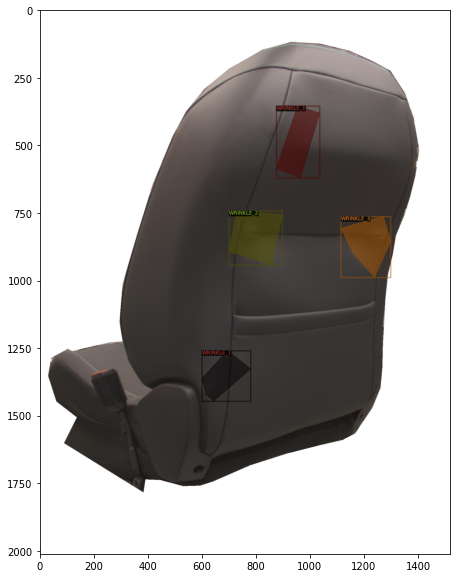

In [ ]:
# visualize annotated images
visualize_annotated_images(train_dataset2,
                           train_dataset_metadata2)

#### 3.2 - Training

In [ ]:
# train
train(train_dataset_name = train_dataset_name2, 
      pretrained_model_name = pretrained_model_mask_rcnn, 
      nbr_classes = 3,
      iterations = 1000)

[INFO   ] defaults:build_model:436 - Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[03/23 03:04:50 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[INFO   ] build:filter_images_with_only_crowd_annotations:63 - Removed 2 images with no usable annotations. 22 images left.
[INFO   ] build:filter_images_with_only_crowd_annotations:63 - Removed 2 images with no usable annotations. 22 images left.


[03/23 03:04:50 d2.data.build]: Removed 2 images with no usable annotations. 22 images left.


[INFO   ] dataset_mapper:__init__:83 - [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[INFO   ] dataset_mapper:__init__:83 - [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]


[03/23 03:04:50 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]


[INFO   ] build:_train_loader_from_config:316 - Using training sampler TrainingSampler
[INFO   ] build:_train_loader_from_config:316 - Using training sampler TrainingSampler


[03/23 03:04:50 d2.data.build]: Using training sampler TrainingSampler


[INFO   ] common:__init__:90 - Serializing 22 elements to byte tensors and concatenating them all ...
[INFO   ] common:__init__:90 - Serializing 22 elements to byte tensors and concatenating them all ...


[03/23 03:04:50 d2.data.common]: Serializing 22 elements to byte tensors and concatenating them all ...


[INFO   ] common:__init__:97 - Serialized dataset takes 0.02 MiB
[INFO   ] common:__init__:97 - Serialized dataset takes 0.02 MiB


[03/23 03:04:50 d2.data.common]: Serialized dataset takes 0.02 MiB


[INFO   ] checkpoint:load:138 - Loading checkpoint from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl
[INFO   ] detection_checkpoint:_load_file:44 - Reading a file from 'Detectron2 Model Zoo'
[WARNING] checkpoint:_log_incompatible_keys:331 - Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
[WARNING] checkpoint:_log_incompatible_keys:331 - Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
[WARNING] checkpoint:_log_incompatible_keys:331 - Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the mo

[03/23 03:04:50 d2.engine.train_loop]: Starting training from iteration 0


[INFO   ] events:write:258 -  eta: 0:13:22  iter: 19  total_loss: 3.635  loss_cls: 1.28  loss_box_reg: 0.0008619  loss_mask: 0.6932  loss_rpn_cls: 1.545  loss_rpn_loc: 0.09357  time: 0.8114  data_time: 0.5236  lr: 4.9953e-06  max_mem: 3013M
[INFO   ] events:write:258 -  eta: 0:13:22  iter: 19  total_loss: 3.635  loss_cls: 1.28  loss_box_reg: 0.0008619  loss_mask: 0.6932  loss_rpn_cls: 1.545  loss_rpn_loc: 0.09357  time: 0.8114  data_time: 0.5236  lr: 4.9953e-06  max_mem: 3013M


[03/23 03:05:07 d2.utils.events]:  eta: 0:13:22  iter: 19  total_loss: 3.635  loss_cls: 1.28  loss_box_reg: 0.0008619  loss_mask: 0.6932  loss_rpn_cls: 1.545  loss_rpn_loc: 0.09357  time: 0.8114  data_time: 0.5236  lr: 4.9953e-06  max_mem: 3013M


[INFO   ] events:write:258 -  eta: 0:13:11  iter: 39  total_loss: 3.379  loss_cls: 1.07  loss_box_reg: 0.0006977  loss_mask: 0.692  loss_rpn_cls: 1.495  loss_rpn_loc: 0.09491  time: 0.8122  data_time: 0.4941  lr: 9.9902e-06  max_mem: 3013M
[INFO   ] events:write:258 -  eta: 0:13:11  iter: 39  total_loss: 3.379  loss_cls: 1.07  loss_box_reg: 0.0006977  loss_mask: 0.692  loss_rpn_cls: 1.495  loss_rpn_loc: 0.09491  time: 0.8122  data_time: 0.4941  lr: 9.9902e-06  max_mem: 3013M


[03/23 03:05:23 d2.utils.events]:  eta: 0:13:11  iter: 39  total_loss: 3.379  loss_cls: 1.07  loss_box_reg: 0.0006977  loss_mask: 0.692  loss_rpn_cls: 1.495  loss_rpn_loc: 0.09491  time: 0.8122  data_time: 0.4941  lr: 9.9902e-06  max_mem: 3013M


[INFO   ] events:write:258 -  eta: 0:12:45  iter: 59  total_loss: 2.891  loss_cls: 0.7185  loss_box_reg: 0.0007049  loss_mask: 0.6897  loss_rpn_cls: 1.369  loss_rpn_loc: 0.1088  time: 0.8125  data_time: 0.4904  lr: 1.4985e-05  max_mem: 3013M
[INFO   ] events:write:258 -  eta: 0:12:45  iter: 59  total_loss: 2.891  loss_cls: 0.7185  loss_box_reg: 0.0007049  loss_mask: 0.6897  loss_rpn_cls: 1.369  loss_rpn_loc: 0.1088  time: 0.8125  data_time: 0.4904  lr: 1.4985e-05  max_mem: 3013M


[03/23 03:05:39 d2.utils.events]:  eta: 0:12:45  iter: 59  total_loss: 2.891  loss_cls: 0.7185  loss_box_reg: 0.0007049  loss_mask: 0.6897  loss_rpn_cls: 1.369  loss_rpn_loc: 0.1088  time: 0.8125  data_time: 0.4904  lr: 1.4985e-05  max_mem: 3013M


[INFO   ] events:write:258 -  eta: 0:12:28  iter: 79  total_loss: 1.854  loss_cls: 0.3921  loss_box_reg: 0.002587  loss_mask: 0.687  loss_rpn_cls: 0.6198  loss_rpn_loc: 0.08212  time: 0.8097  data_time: 0.4909  lr: 1.998e-05  max_mem: 3013M
[INFO   ] events:write:258 -  eta: 0:12:28  iter: 79  total_loss: 1.854  loss_cls: 0.3921  loss_box_reg: 0.002587  loss_mask: 0.687  loss_rpn_cls: 0.6198  loss_rpn_loc: 0.08212  time: 0.8097  data_time: 0.4909  lr: 1.998e-05  max_mem: 3013M


[03/23 03:05:55 d2.utils.events]:  eta: 0:12:28  iter: 79  total_loss: 1.854  loss_cls: 0.3921  loss_box_reg: 0.002587  loss_mask: 0.687  loss_rpn_cls: 0.6198  loss_rpn_loc: 0.08212  time: 0.8097  data_time: 0.4909  lr: 1.998e-05  max_mem: 3013M


[INFO   ] events:write:258 -  eta: 0:12:12  iter: 99  total_loss: 1.343  loss_cls: 0.2166  loss_box_reg: 0.0004177  loss_mask: 0.6823  loss_rpn_cls: 0.3344  loss_rpn_loc: 0.08047  time: 0.8117  data_time: 0.5129  lr: 2.4975e-05  max_mem: 3013M
[INFO   ] events:write:258 -  eta: 0:12:12  iter: 99  total_loss: 1.343  loss_cls: 0.2166  loss_box_reg: 0.0004177  loss_mask: 0.6823  loss_rpn_cls: 0.3344  loss_rpn_loc: 0.08047  time: 0.8117  data_time: 0.5129  lr: 2.4975e-05  max_mem: 3013M


[03/23 03:06:12 d2.utils.events]:  eta: 0:12:12  iter: 99  total_loss: 1.343  loss_cls: 0.2166  loss_box_reg: 0.0004177  loss_mask: 0.6823  loss_rpn_cls: 0.3344  loss_rpn_loc: 0.08047  time: 0.8117  data_time: 0.5129  lr: 2.4975e-05  max_mem: 3013M


[INFO   ] events:write:258 -  eta: 0:11:56  iter: 119  total_loss: 1.157  loss_cls: 0.1075  loss_box_reg: 0.01589  loss_mask: 0.6781  loss_rpn_cls: 0.2467  loss_rpn_loc: 0.1055  time: 0.8104  data_time: 0.4989  lr: 2.997e-05  max_mem: 3013M
[INFO   ] events:write:258 -  eta: 0:11:56  iter: 119  total_loss: 1.157  loss_cls: 0.1075  loss_box_reg: 0.01589  loss_mask: 0.6781  loss_rpn_cls: 0.2467  loss_rpn_loc: 0.1055  time: 0.8104  data_time: 0.4989  lr: 2.997e-05  max_mem: 3013M


[03/23 03:06:28 d2.utils.events]:  eta: 0:11:56  iter: 119  total_loss: 1.157  loss_cls: 0.1075  loss_box_reg: 0.01589  loss_mask: 0.6781  loss_rpn_cls: 0.2467  loss_rpn_loc: 0.1055  time: 0.8104  data_time: 0.4989  lr: 2.997e-05  max_mem: 3013M


[INFO   ] events:write:258 -  eta: 0:11:39  iter: 139  total_loss: 1.046  loss_cls: 0.1024  loss_box_reg: 0.01589  loss_mask: 0.6729  loss_rpn_cls: 0.1556  loss_rpn_loc: 0.08817  time: 0.8106  data_time: 0.5035  lr: 3.4965e-05  max_mem: 3013M
[INFO   ] events:write:258 -  eta: 0:11:39  iter: 139  total_loss: 1.046  loss_cls: 0.1024  loss_box_reg: 0.01589  loss_mask: 0.6729  loss_rpn_cls: 0.1556  loss_rpn_loc: 0.08817  time: 0.8106  data_time: 0.5035  lr: 3.4965e-05  max_mem: 3013M


[03/23 03:06:44 d2.utils.events]:  eta: 0:11:39  iter: 139  total_loss: 1.046  loss_cls: 0.1024  loss_box_reg: 0.01589  loss_mask: 0.6729  loss_rpn_cls: 0.1556  loss_rpn_loc: 0.08817  time: 0.8106  data_time: 0.5035  lr: 3.4965e-05  max_mem: 3013M


[INFO   ] events:write:258 -  eta: 0:11:23  iter: 159  total_loss: 1.04  loss_cls: 0.1273  loss_box_reg: 0.04395  loss_mask: 0.6683  loss_rpn_cls: 0.1466  loss_rpn_loc: 0.08801  time: 0.8104  data_time: 0.4857  lr: 3.996e-05  max_mem: 3013M
[INFO   ] events:write:258 -  eta: 0:11:23  iter: 159  total_loss: 1.04  loss_cls: 0.1273  loss_box_reg: 0.04395  loss_mask: 0.6683  loss_rpn_cls: 0.1466  loss_rpn_loc: 0.08801  time: 0.8104  data_time: 0.4857  lr: 3.996e-05  max_mem: 3013M


[03/23 03:07:01 d2.utils.events]:  eta: 0:11:23  iter: 159  total_loss: 1.04  loss_cls: 0.1273  loss_box_reg: 0.04395  loss_mask: 0.6683  loss_rpn_cls: 0.1466  loss_rpn_loc: 0.08801  time: 0.8104  data_time: 0.4857  lr: 3.996e-05  max_mem: 3013M


[INFO   ] events:write:258 -  eta: 0:11:07  iter: 179  total_loss: 1.065  loss_cls: 0.1468  loss_box_reg: 0.06541  loss_mask: 0.669  loss_rpn_cls: 0.1408  loss_rpn_loc: 0.05397  time: 0.8110  data_time: 0.5004  lr: 4.4955e-05  max_mem: 3013M
[INFO   ] events:write:258 -  eta: 0:11:07  iter: 179  total_loss: 1.065  loss_cls: 0.1468  loss_box_reg: 0.06541  loss_mask: 0.669  loss_rpn_cls: 0.1408  loss_rpn_loc: 0.05397  time: 0.8110  data_time: 0.5004  lr: 4.4955e-05  max_mem: 3013M


[03/23 03:07:17 d2.utils.events]:  eta: 0:11:07  iter: 179  total_loss: 1.065  loss_cls: 0.1468  loss_box_reg: 0.06541  loss_mask: 0.669  loss_rpn_cls: 0.1408  loss_rpn_loc: 0.05397  time: 0.8110  data_time: 0.5004  lr: 4.4955e-05  max_mem: 3013M


[INFO   ] events:write:258 -  eta: 0:10:51  iter: 199  total_loss: 1.061  loss_cls: 0.1558  loss_box_reg: 0.0677  loss_mask: 0.6599  loss_rpn_cls: 0.1164  loss_rpn_loc: 0.06812  time: 0.8126  data_time: 0.5033  lr: 4.995e-05  max_mem: 3013M
[INFO   ] events:write:258 -  eta: 0:10:51  iter: 199  total_loss: 1.061  loss_cls: 0.1558  loss_box_reg: 0.0677  loss_mask: 0.6599  loss_rpn_cls: 0.1164  loss_rpn_loc: 0.06812  time: 0.8126  data_time: 0.5033  lr: 4.995e-05  max_mem: 3013M


[03/23 03:07:33 d2.utils.events]:  eta: 0:10:51  iter: 199  total_loss: 1.061  loss_cls: 0.1558  loss_box_reg: 0.0677  loss_mask: 0.6599  loss_rpn_cls: 0.1164  loss_rpn_loc: 0.06812  time: 0.8126  data_time: 0.5033  lr: 4.995e-05  max_mem: 3013M


[INFO   ] events:write:258 -  eta: 0:10:35  iter: 219  total_loss: 1.169  loss_cls: 0.1836  loss_box_reg: 0.08546  loss_mask: 0.6589  loss_rpn_cls: 0.1154  loss_rpn_loc: 0.09445  time: 0.8140  data_time: 0.5075  lr: 5.4945e-05  max_mem: 3013M
[INFO   ] events:write:258 -  eta: 0:10:35  iter: 219  total_loss: 1.169  loss_cls: 0.1836  loss_box_reg: 0.08546  loss_mask: 0.6589  loss_rpn_cls: 0.1154  loss_rpn_loc: 0.09445  time: 0.8140  data_time: 0.5075  lr: 5.4945e-05  max_mem: 3013M


[03/23 03:07:50 d2.utils.events]:  eta: 0:10:35  iter: 219  total_loss: 1.169  loss_cls: 0.1836  loss_box_reg: 0.08546  loss_mask: 0.6589  loss_rpn_cls: 0.1154  loss_rpn_loc: 0.09445  time: 0.8140  data_time: 0.5075  lr: 5.4945e-05  max_mem: 3013M


[INFO   ] events:write:258 -  eta: 0:10:18  iter: 239  total_loss: 1.112  loss_cls: 0.1858  loss_box_reg: 0.09604  loss_mask: 0.6503  loss_rpn_cls: 0.1066  loss_rpn_loc: 0.08497  time: 0.8134  data_time: 0.4843  lr: 5.994e-05  max_mem: 3013M
[INFO   ] events:write:258 -  eta: 0:10:18  iter: 239  total_loss: 1.112  loss_cls: 0.1858  loss_box_reg: 0.09604  loss_mask: 0.6503  loss_rpn_cls: 0.1066  loss_rpn_loc: 0.08497  time: 0.8134  data_time: 0.4843  lr: 5.994e-05  max_mem: 3013M


[03/23 03:08:06 d2.utils.events]:  eta: 0:10:18  iter: 239  total_loss: 1.112  loss_cls: 0.1858  loss_box_reg: 0.09604  loss_mask: 0.6503  loss_rpn_cls: 0.1066  loss_rpn_loc: 0.08497  time: 0.8134  data_time: 0.4843  lr: 5.994e-05  max_mem: 3013M


[INFO   ] events:write:258 -  eta: 0:10:02  iter: 259  total_loss: 1.069  loss_cls: 0.1738  loss_box_reg: 0.08365  loss_mask: 0.6579  loss_rpn_cls: 0.09254  loss_rpn_loc: 0.06968  time: 0.8126  data_time: 0.4709  lr: 6.4935e-05  max_mem: 3013M
[INFO   ] events:write:258 -  eta: 0:10:02  iter: 259  total_loss: 1.069  loss_cls: 0.1738  loss_box_reg: 0.08365  loss_mask: 0.6579  loss_rpn_cls: 0.09254  loss_rpn_loc: 0.06968  time: 0.8126  data_time: 0.4709  lr: 6.4935e-05  max_mem: 3013M


[03/23 03:08:22 d2.utils.events]:  eta: 0:10:02  iter: 259  total_loss: 1.069  loss_cls: 0.1738  loss_box_reg: 0.08365  loss_mask: 0.6579  loss_rpn_cls: 0.09254  loss_rpn_loc: 0.06968  time: 0.8126  data_time: 0.4709  lr: 6.4935e-05  max_mem: 3013M


[INFO   ] events:write:258 -  eta: 0:09:46  iter: 279  total_loss: 1.073  loss_cls: 0.1952  loss_box_reg: 0.1198  loss_mask: 0.6442  loss_rpn_cls: 0.08993  loss_rpn_loc: 0.04797  time: 0.8118  data_time: 0.4797  lr: 6.993e-05  max_mem: 3013M
[INFO   ] events:write:258 -  eta: 0:09:46  iter: 279  total_loss: 1.073  loss_cls: 0.1952  loss_box_reg: 0.1198  loss_mask: 0.6442  loss_rpn_cls: 0.08993  loss_rpn_loc: 0.04797  time: 0.8118  data_time: 0.4797  lr: 6.993e-05  max_mem: 3013M


[03/23 03:08:38 d2.utils.events]:  eta: 0:09:46  iter: 279  total_loss: 1.073  loss_cls: 0.1952  loss_box_reg: 0.1198  loss_mask: 0.6442  loss_rpn_cls: 0.08993  loss_rpn_loc: 0.04797  time: 0.8118  data_time: 0.4797  lr: 6.993e-05  max_mem: 3013M


[INFO   ] events:write:258 -  eta: 0:09:29  iter: 299  total_loss: 1.107  loss_cls: 0.2139  loss_box_reg: 0.1395  loss_mask: 0.6239  loss_rpn_cls: 0.07514  loss_rpn_loc: 0.07485  time: 0.8119  data_time: 0.4877  lr: 7.4925e-05  max_mem: 3013M
[INFO   ] events:write:258 -  eta: 0:09:29  iter: 299  total_loss: 1.107  loss_cls: 0.2139  loss_box_reg: 0.1395  loss_mask: 0.6239  loss_rpn_cls: 0.07514  loss_rpn_loc: 0.07485  time: 0.8119  data_time: 0.4877  lr: 7.4925e-05  max_mem: 3013M


[03/23 03:08:55 d2.utils.events]:  eta: 0:09:29  iter: 299  total_loss: 1.107  loss_cls: 0.2139  loss_box_reg: 0.1395  loss_mask: 0.6239  loss_rpn_cls: 0.07514  loss_rpn_loc: 0.07485  time: 0.8119  data_time: 0.4877  lr: 7.4925e-05  max_mem: 3013M


[INFO   ] events:write:258 -  eta: 0:09:14  iter: 319  total_loss: 1.125  loss_cls: 0.2246  loss_box_reg: 0.1475  loss_mask: 0.625  loss_rpn_cls: 0.07534  loss_rpn_loc: 0.05296  time: 0.8133  data_time: 0.4947  lr: 7.992e-05  max_mem: 3013M
[INFO   ] events:write:258 -  eta: 0:09:14  iter: 319  total_loss: 1.125  loss_cls: 0.2246  loss_box_reg: 0.1475  loss_mask: 0.625  loss_rpn_cls: 0.07534  loss_rpn_loc: 0.05296  time: 0.8133  data_time: 0.4947  lr: 7.992e-05  max_mem: 3013M


[03/23 03:09:11 d2.utils.events]:  eta: 0:09:14  iter: 319  total_loss: 1.125  loss_cls: 0.2246  loss_box_reg: 0.1475  loss_mask: 0.625  loss_rpn_cls: 0.07534  loss_rpn_loc: 0.05296  time: 0.8133  data_time: 0.4947  lr: 7.992e-05  max_mem: 3013M


[INFO   ] events:write:258 -  eta: 0:08:59  iter: 339  total_loss: 1.2  loss_cls: 0.2502  loss_box_reg: 0.1629  loss_mask: 0.6269  loss_rpn_cls: 0.0852  loss_rpn_loc: 0.06019  time: 0.8139  data_time: 0.4939  lr: 8.4915e-05  max_mem: 3013M
[INFO   ] events:write:258 -  eta: 0:08:59  iter: 339  total_loss: 1.2  loss_cls: 0.2502  loss_box_reg: 0.1629  loss_mask: 0.6269  loss_rpn_cls: 0.0852  loss_rpn_loc: 0.06019  time: 0.8139  data_time: 0.4939  lr: 8.4915e-05  max_mem: 3013M


[03/23 03:09:28 d2.utils.events]:  eta: 0:08:59  iter: 339  total_loss: 1.2  loss_cls: 0.2502  loss_box_reg: 0.1629  loss_mask: 0.6269  loss_rpn_cls: 0.0852  loss_rpn_loc: 0.06019  time: 0.8139  data_time: 0.4939  lr: 8.4915e-05  max_mem: 3013M


[INFO   ] events:write:258 -  eta: 0:08:43  iter: 359  total_loss: 1.147  loss_cls: 0.2342  loss_box_reg: 0.1696  loss_mask: 0.6036  loss_rpn_cls: 0.08104  loss_rpn_loc: 0.06277  time: 0.8151  data_time: 0.4965  lr: 8.991e-05  max_mem: 3013M
[INFO   ] events:write:258 -  eta: 0:08:43  iter: 359  total_loss: 1.147  loss_cls: 0.2342  loss_box_reg: 0.1696  loss_mask: 0.6036  loss_rpn_cls: 0.08104  loss_rpn_loc: 0.06277  time: 0.8151  data_time: 0.4965  lr: 8.991e-05  max_mem: 3013M


[03/23 03:09:45 d2.utils.events]:  eta: 0:08:43  iter: 359  total_loss: 1.147  loss_cls: 0.2342  loss_box_reg: 0.1696  loss_mask: 0.6036  loss_rpn_cls: 0.08104  loss_rpn_loc: 0.06277  time: 0.8151  data_time: 0.4965  lr: 8.991e-05  max_mem: 3013M


[INFO   ] events:write:258 -  eta: 0:08:27  iter: 379  total_loss: 1.185  loss_cls: 0.2461  loss_box_reg: 0.1685  loss_mask: 0.5896  loss_rpn_cls: 0.06065  loss_rpn_loc: 0.08441  time: 0.8154  data_time: 0.4912  lr: 9.4905e-05  max_mem: 3013M
[INFO   ] events:write:258 -  eta: 0:08:27  iter: 379  total_loss: 1.185  loss_cls: 0.2461  loss_box_reg: 0.1685  loss_mask: 0.5896  loss_rpn_cls: 0.06065  loss_rpn_loc: 0.08441  time: 0.8154  data_time: 0.4912  lr: 9.4905e-05  max_mem: 3013M


[03/23 03:10:01 d2.utils.events]:  eta: 0:08:27  iter: 379  total_loss: 1.185  loss_cls: 0.2461  loss_box_reg: 0.1685  loss_mask: 0.5896  loss_rpn_cls: 0.06065  loss_rpn_loc: 0.08441  time: 0.8154  data_time: 0.4912  lr: 9.4905e-05  max_mem: 3013M


[INFO   ] events:write:258 -  eta: 0:08:10  iter: 399  total_loss: 1.077  loss_cls: 0.2296  loss_box_reg: 0.1738  loss_mask: 0.576  loss_rpn_cls: 0.05962  loss_rpn_loc: 0.04143  time: 0.8154  data_time: 0.4766  lr: 9.99e-05  max_mem: 3013M
[INFO   ] events:write:258 -  eta: 0:08:10  iter: 399  total_loss: 1.077  loss_cls: 0.2296  loss_box_reg: 0.1738  loss_mask: 0.576  loss_rpn_cls: 0.05962  loss_rpn_loc: 0.04143  time: 0.8154  data_time: 0.4766  lr: 9.99e-05  max_mem: 3013M


[03/23 03:10:17 d2.utils.events]:  eta: 0:08:10  iter: 399  total_loss: 1.077  loss_cls: 0.2296  loss_box_reg: 0.1738  loss_mask: 0.576  loss_rpn_cls: 0.05962  loss_rpn_loc: 0.04143  time: 0.8154  data_time: 0.4766  lr: 9.99e-05  max_mem: 3013M


[INFO   ] events:write:258 -  eta: 0:07:54  iter: 419  total_loss: 1.21  loss_cls: 0.278  loss_box_reg: 0.2334  loss_mask: 0.565  loss_rpn_cls: 0.05351  loss_rpn_loc: 0.06308  time: 0.8156  data_time: 0.4748  lr: 0.0001049  max_mem: 3013M
[INFO   ] events:write:258 -  eta: 0:07:54  iter: 419  total_loss: 1.21  loss_cls: 0.278  loss_box_reg: 0.2334  loss_mask: 0.565  loss_rpn_cls: 0.05351  loss_rpn_loc: 0.06308  time: 0.8156  data_time: 0.4748  lr: 0.0001049  max_mem: 3013M


[03/23 03:10:34 d2.utils.events]:  eta: 0:07:54  iter: 419  total_loss: 1.21  loss_cls: 0.278  loss_box_reg: 0.2334  loss_mask: 0.565  loss_rpn_cls: 0.05351  loss_rpn_loc: 0.06308  time: 0.8156  data_time: 0.4748  lr: 0.0001049  max_mem: 3013M


[INFO   ] events:write:258 -  eta: 0:07:37  iter: 439  total_loss: 1.193  loss_cls: 0.2666  loss_box_reg: 0.2143  loss_mask: 0.5441  loss_rpn_cls: 0.0488  loss_rpn_loc: 0.05825  time: 0.8160  data_time: 0.4799  lr: 0.00010989  max_mem: 3013M
[INFO   ] events:write:258 -  eta: 0:07:37  iter: 439  total_loss: 1.193  loss_cls: 0.2666  loss_box_reg: 0.2143  loss_mask: 0.5441  loss_rpn_cls: 0.0488  loss_rpn_loc: 0.05825  time: 0.8160  data_time: 0.4799  lr: 0.00010989  max_mem: 3013M


[03/23 03:10:50 d2.utils.events]:  eta: 0:07:37  iter: 439  total_loss: 1.193  loss_cls: 0.2666  loss_box_reg: 0.2143  loss_mask: 0.5441  loss_rpn_cls: 0.0488  loss_rpn_loc: 0.05825  time: 0.8160  data_time: 0.4799  lr: 0.00010989  max_mem: 3013M


[INFO   ] events:write:258 -  eta: 0:07:21  iter: 459  total_loss: 1.195  loss_cls: 0.2869  loss_box_reg: 0.2541  loss_mask: 0.5374  loss_rpn_cls: 0.05264  loss_rpn_loc: 0.04444  time: 0.8163  data_time: 0.4710  lr: 0.00011489  max_mem: 3013M
[INFO   ] events:write:258 -  eta: 0:07:21  iter: 459  total_loss: 1.195  loss_cls: 0.2869  loss_box_reg: 0.2541  loss_mask: 0.5374  loss_rpn_cls: 0.05264  loss_rpn_loc: 0.04444  time: 0.8163  data_time: 0.4710  lr: 0.00011489  max_mem: 3013M


[03/23 03:11:07 d2.utils.events]:  eta: 0:07:21  iter: 459  total_loss: 1.195  loss_cls: 0.2869  loss_box_reg: 0.2541  loss_mask: 0.5374  loss_rpn_cls: 0.05264  loss_rpn_loc: 0.04444  time: 0.8163  data_time: 0.4710  lr: 0.00011489  max_mem: 3013M


[INFO   ] events:write:258 -  eta: 0:07:04  iter: 479  total_loss: 1.194  loss_cls: 0.2782  loss_box_reg: 0.2336  loss_mask: 0.5253  loss_rpn_cls: 0.05495  loss_rpn_loc: 0.05687  time: 0.8157  data_time: 0.4530  lr: 0.00011988  max_mem: 3013M
[INFO   ] events:write:258 -  eta: 0:07:04  iter: 479  total_loss: 1.194  loss_cls: 0.2782  loss_box_reg: 0.2336  loss_mask: 0.5253  loss_rpn_cls: 0.05495  loss_rpn_loc: 0.05687  time: 0.8157  data_time: 0.4530  lr: 0.00011988  max_mem: 3013M


[03/23 03:11:23 d2.utils.events]:  eta: 0:07:04  iter: 479  total_loss: 1.194  loss_cls: 0.2782  loss_box_reg: 0.2336  loss_mask: 0.5253  loss_rpn_cls: 0.05495  loss_rpn_loc: 0.05687  time: 0.8157  data_time: 0.4530  lr: 0.00011988  max_mem: 3013M


[INFO   ] events:write:258 -  eta: 0:06:48  iter: 499  total_loss: 1.124  loss_cls: 0.2743  loss_box_reg: 0.2527  loss_mask: 0.5132  loss_rpn_cls: 0.04647  loss_rpn_loc: 0.04311  time: 0.8158  data_time: 0.4744  lr: 0.00012488  max_mem: 3013M
[INFO   ] events:write:258 -  eta: 0:06:48  iter: 499  total_loss: 1.124  loss_cls: 0.2743  loss_box_reg: 0.2527  loss_mask: 0.5132  loss_rpn_cls: 0.04647  loss_rpn_loc: 0.04311  time: 0.8158  data_time: 0.4744  lr: 0.00012488  max_mem: 3013M


[03/23 03:11:39 d2.utils.events]:  eta: 0:06:48  iter: 499  total_loss: 1.124  loss_cls: 0.2743  loss_box_reg: 0.2527  loss_mask: 0.5132  loss_rpn_cls: 0.04647  loss_rpn_loc: 0.04311  time: 0.8158  data_time: 0.4744  lr: 0.00012488  max_mem: 3013M


[INFO   ] events:write:258 -  eta: 0:06:32  iter: 519  total_loss: 1.153  loss_cls: 0.2865  loss_box_reg: 0.2735  loss_mask: 0.5051  loss_rpn_cls: 0.04309  loss_rpn_loc: 0.05022  time: 0.8156  data_time: 0.4551  lr: 0.00012987  max_mem: 3044M
[INFO   ] events:write:258 -  eta: 0:06:32  iter: 519  total_loss: 1.153  loss_cls: 0.2865  loss_box_reg: 0.2735  loss_mask: 0.5051  loss_rpn_cls: 0.04309  loss_rpn_loc: 0.05022  time: 0.8156  data_time: 0.4551  lr: 0.00012987  max_mem: 3044M


[03/23 03:11:56 d2.utils.events]:  eta: 0:06:32  iter: 519  total_loss: 1.153  loss_cls: 0.2865  loss_box_reg: 0.2735  loss_mask: 0.5051  loss_rpn_cls: 0.04309  loss_rpn_loc: 0.05022  time: 0.8156  data_time: 0.4551  lr: 0.00012987  max_mem: 3044M


[INFO   ] events:write:258 -  eta: 0:06:16  iter: 539  total_loss: 1.187  loss_cls: 0.2945  loss_box_reg: 0.2901  loss_mask: 0.5008  loss_rpn_cls: 0.04104  loss_rpn_loc: 0.05308  time: 0.8152  data_time: 0.4693  lr: 0.00013487  max_mem: 3044M
[INFO   ] events:write:258 -  eta: 0:06:16  iter: 539  total_loss: 1.187  loss_cls: 0.2945  loss_box_reg: 0.2901  loss_mask: 0.5008  loss_rpn_cls: 0.04104  loss_rpn_loc: 0.05308  time: 0.8152  data_time: 0.4693  lr: 0.00013487  max_mem: 3044M


[03/23 03:12:12 d2.utils.events]:  eta: 0:06:16  iter: 539  total_loss: 1.187  loss_cls: 0.2945  loss_box_reg: 0.2901  loss_mask: 0.5008  loss_rpn_cls: 0.04104  loss_rpn_loc: 0.05308  time: 0.8152  data_time: 0.4693  lr: 0.00013487  max_mem: 3044M


[INFO   ] events:write:258 -  eta: 0:05:59  iter: 559  total_loss: 1.124  loss_cls: 0.2712  loss_box_reg: 0.2677  loss_mask: 0.5046  loss_rpn_cls: 0.04472  loss_rpn_loc: 0.05037  time: 0.8151  data_time: 0.4575  lr: 0.00013986  max_mem: 3068M
[INFO   ] events:write:258 -  eta: 0:05:59  iter: 559  total_loss: 1.124  loss_cls: 0.2712  loss_box_reg: 0.2677  loss_mask: 0.5046  loss_rpn_cls: 0.04472  loss_rpn_loc: 0.05037  time: 0.8151  data_time: 0.4575  lr: 0.00013986  max_mem: 3068M


[03/23 03:12:28 d2.utils.events]:  eta: 0:05:59  iter: 559  total_loss: 1.124  loss_cls: 0.2712  loss_box_reg: 0.2677  loss_mask: 0.5046  loss_rpn_cls: 0.04472  loss_rpn_loc: 0.05037  time: 0.8151  data_time: 0.4575  lr: 0.00013986  max_mem: 3068M


[INFO   ] events:write:258 -  eta: 0:05:42  iter: 579  total_loss: 1.274  loss_cls: 0.3252  loss_box_reg: 0.3452  loss_mask: 0.4974  loss_rpn_cls: 0.03725  loss_rpn_loc: 0.04091  time: 0.8146  data_time: 0.4510  lr: 0.00014486  max_mem: 3089M
[INFO   ] events:write:258 -  eta: 0:05:42  iter: 579  total_loss: 1.274  loss_cls: 0.3252  loss_box_reg: 0.3452  loss_mask: 0.4974  loss_rpn_cls: 0.03725  loss_rpn_loc: 0.04091  time: 0.8146  data_time: 0.4510  lr: 0.00014486  max_mem: 3089M


[03/23 03:12:44 d2.utils.events]:  eta: 0:05:42  iter: 579  total_loss: 1.274  loss_cls: 0.3252  loss_box_reg: 0.3452  loss_mask: 0.4974  loss_rpn_cls: 0.03725  loss_rpn_loc: 0.04091  time: 0.8146  data_time: 0.4510  lr: 0.00014486  max_mem: 3089M


[INFO   ] events:write:258 -  eta: 0:05:25  iter: 599  total_loss: 1.134  loss_cls: 0.2854  loss_box_reg: 0.2873  loss_mask: 0.4812  loss_rpn_cls: 0.03433  loss_rpn_loc: 0.05052  time: 0.8146  data_time: 0.4761  lr: 0.00014985  max_mem: 3101M
[INFO   ] events:write:258 -  eta: 0:05:25  iter: 599  total_loss: 1.134  loss_cls: 0.2854  loss_box_reg: 0.2873  loss_mask: 0.4812  loss_rpn_cls: 0.03433  loss_rpn_loc: 0.05052  time: 0.8146  data_time: 0.4761  lr: 0.00014985  max_mem: 3101M


[03/23 03:13:00 d2.utils.events]:  eta: 0:05:25  iter: 599  total_loss: 1.134  loss_cls: 0.2854  loss_box_reg: 0.2873  loss_mask: 0.4812  loss_rpn_cls: 0.03433  loss_rpn_loc: 0.05052  time: 0.8146  data_time: 0.4761  lr: 0.00014985  max_mem: 3101M


[INFO   ] events:write:258 -  eta: 0:05:09  iter: 619  total_loss: 1.201  loss_cls: 0.3076  loss_box_reg: 0.3362  loss_mask: 0.4788  loss_rpn_cls: 0.03254  loss_rpn_loc: 0.04504  time: 0.8142  data_time: 0.4436  lr: 0.00015485  max_mem: 3101M
[INFO   ] events:write:258 -  eta: 0:05:09  iter: 619  total_loss: 1.201  loss_cls: 0.3076  loss_box_reg: 0.3362  loss_mask: 0.4788  loss_rpn_cls: 0.03254  loss_rpn_loc: 0.04504  time: 0.8142  data_time: 0.4436  lr: 0.00015485  max_mem: 3101M


[03/23 03:13:16 d2.utils.events]:  eta: 0:05:09  iter: 619  total_loss: 1.201  loss_cls: 0.3076  loss_box_reg: 0.3362  loss_mask: 0.4788  loss_rpn_cls: 0.03254  loss_rpn_loc: 0.04504  time: 0.8142  data_time: 0.4436  lr: 0.00015485  max_mem: 3101M


[INFO   ] events:write:258 -  eta: 0:04:53  iter: 639  total_loss: 1.197  loss_cls: 0.3019  loss_box_reg: 0.3134  loss_mask: 0.4767  loss_rpn_cls: 0.03417  loss_rpn_loc: 0.05032  time: 0.8137  data_time: 0.4515  lr: 0.00015984  max_mem: 3101M
[INFO   ] events:write:258 -  eta: 0:04:53  iter: 639  total_loss: 1.197  loss_cls: 0.3019  loss_box_reg: 0.3134  loss_mask: 0.4767  loss_rpn_cls: 0.03417  loss_rpn_loc: 0.05032  time: 0.8137  data_time: 0.4515  lr: 0.00015984  max_mem: 3101M


[03/23 03:13:32 d2.utils.events]:  eta: 0:04:53  iter: 639  total_loss: 1.197  loss_cls: 0.3019  loss_box_reg: 0.3134  loss_mask: 0.4767  loss_rpn_cls: 0.03417  loss_rpn_loc: 0.05032  time: 0.8137  data_time: 0.4515  lr: 0.00015984  max_mem: 3101M


[INFO   ] events:write:258 -  eta: 0:04:36  iter: 659  total_loss: 1.177  loss_cls: 0.292  loss_box_reg: 0.3336  loss_mask: 0.469  loss_rpn_cls: 0.03193  loss_rpn_loc: 0.04351  time: 0.8137  data_time: 0.4606  lr: 0.00016484  max_mem: 3101M
[INFO   ] events:write:258 -  eta: 0:04:36  iter: 659  total_loss: 1.177  loss_cls: 0.292  loss_box_reg: 0.3336  loss_mask: 0.469  loss_rpn_cls: 0.03193  loss_rpn_loc: 0.04351  time: 0.8137  data_time: 0.4606  lr: 0.00016484  max_mem: 3101M


[03/23 03:13:49 d2.utils.events]:  eta: 0:04:36  iter: 659  total_loss: 1.177  loss_cls: 0.292  loss_box_reg: 0.3336  loss_mask: 0.469  loss_rpn_cls: 0.03193  loss_rpn_loc: 0.04351  time: 0.8137  data_time: 0.4606  lr: 0.00016484  max_mem: 3101M


[INFO   ] events:write:258 -  eta: 0:04:20  iter: 679  total_loss: 1.178  loss_cls: 0.2985  loss_box_reg: 0.3154  loss_mask: 0.4718  loss_rpn_cls: 0.02991  loss_rpn_loc: 0.0483  time: 0.8132  data_time: 0.4325  lr: 0.00016983  max_mem: 3101M
[INFO   ] events:write:258 -  eta: 0:04:20  iter: 679  total_loss: 1.178  loss_cls: 0.2985  loss_box_reg: 0.3154  loss_mask: 0.4718  loss_rpn_cls: 0.02991  loss_rpn_loc: 0.0483  time: 0.8132  data_time: 0.4325  lr: 0.00016983  max_mem: 3101M


[03/23 03:14:05 d2.utils.events]:  eta: 0:04:20  iter: 679  total_loss: 1.178  loss_cls: 0.2985  loss_box_reg: 0.3154  loss_mask: 0.4718  loss_rpn_cls: 0.02991  loss_rpn_loc: 0.0483  time: 0.8132  data_time: 0.4325  lr: 0.00016983  max_mem: 3101M


[INFO   ] events:write:258 -  eta: 0:04:04  iter: 699  total_loss: 1.158  loss_cls: 0.2972  loss_box_reg: 0.3237  loss_mask: 0.4541  loss_rpn_cls: 0.02429  loss_rpn_loc: 0.04478  time: 0.8133  data_time: 0.4588  lr: 0.00017483  max_mem: 3354M
[INFO   ] events:write:258 -  eta: 0:04:04  iter: 699  total_loss: 1.158  loss_cls: 0.2972  loss_box_reg: 0.3237  loss_mask: 0.4541  loss_rpn_cls: 0.02429  loss_rpn_loc: 0.04478  time: 0.8133  data_time: 0.4588  lr: 0.00017483  max_mem: 3354M


[03/23 03:14:21 d2.utils.events]:  eta: 0:04:04  iter: 699  total_loss: 1.158  loss_cls: 0.2972  loss_box_reg: 0.3237  loss_mask: 0.4541  loss_rpn_cls: 0.02429  loss_rpn_loc: 0.04478  time: 0.8133  data_time: 0.4588  lr: 0.00017483  max_mem: 3354M


[INFO   ] events:write:258 -  eta: 0:03:47  iter: 719  total_loss: 1.187  loss_cls: 0.3056  loss_box_reg: 0.3439  loss_mask: 0.4411  loss_rpn_cls: 0.02833  loss_rpn_loc: 0.03871  time: 0.8136  data_time: 0.4634  lr: 0.00017982  max_mem: 3354M
[INFO   ] events:write:258 -  eta: 0:03:47  iter: 719  total_loss: 1.187  loss_cls: 0.3056  loss_box_reg: 0.3439  loss_mask: 0.4411  loss_rpn_cls: 0.02833  loss_rpn_loc: 0.03871  time: 0.8136  data_time: 0.4634  lr: 0.00017982  max_mem: 3354M


[03/23 03:14:38 d2.utils.events]:  eta: 0:03:47  iter: 719  total_loss: 1.187  loss_cls: 0.3056  loss_box_reg: 0.3439  loss_mask: 0.4411  loss_rpn_cls: 0.02833  loss_rpn_loc: 0.03871  time: 0.8136  data_time: 0.4634  lr: 0.00017982  max_mem: 3354M


[INFO   ] events:write:258 -  eta: 0:03:31  iter: 739  total_loss: 1.237  loss_cls: 0.3044  loss_box_reg: 0.3459  loss_mask: 0.456  loss_rpn_cls: 0.02427  loss_rpn_loc: 0.04564  time: 0.8141  data_time: 0.4567  lr: 0.00018482  max_mem: 3354M
[INFO   ] events:write:258 -  eta: 0:03:31  iter: 739  total_loss: 1.237  loss_cls: 0.3044  loss_box_reg: 0.3459  loss_mask: 0.456  loss_rpn_cls: 0.02427  loss_rpn_loc: 0.04564  time: 0.8141  data_time: 0.4567  lr: 0.00018482  max_mem: 3354M


[03/23 03:14:54 d2.utils.events]:  eta: 0:03:31  iter: 739  total_loss: 1.237  loss_cls: 0.3044  loss_box_reg: 0.3459  loss_mask: 0.456  loss_rpn_cls: 0.02427  loss_rpn_loc: 0.04564  time: 0.8141  data_time: 0.4567  lr: 0.00018482  max_mem: 3354M


[INFO   ] events:write:258 -  eta: 0:03:15  iter: 759  total_loss: 1.184  loss_cls: 0.3176  loss_box_reg: 0.3677  loss_mask: 0.4393  loss_rpn_cls: 0.01994  loss_rpn_loc: 0.03668  time: 0.8140  data_time: 0.4316  lr: 0.00018981  max_mem: 3354M
[INFO   ] events:write:258 -  eta: 0:03:15  iter: 759  total_loss: 1.184  loss_cls: 0.3176  loss_box_reg: 0.3677  loss_mask: 0.4393  loss_rpn_cls: 0.01994  loss_rpn_loc: 0.03668  time: 0.8140  data_time: 0.4316  lr: 0.00018981  max_mem: 3354M


[03/23 03:15:11 d2.utils.events]:  eta: 0:03:15  iter: 759  total_loss: 1.184  loss_cls: 0.3176  loss_box_reg: 0.3677  loss_mask: 0.4393  loss_rpn_cls: 0.01994  loss_rpn_loc: 0.03668  time: 0.8140  data_time: 0.4316  lr: 0.00018981  max_mem: 3354M


[INFO   ] events:write:258 -  eta: 0:02:59  iter: 779  total_loss: 1.237  loss_cls: 0.3265  loss_box_reg: 0.4264  loss_mask: 0.4379  loss_rpn_cls: 0.02025  loss_rpn_loc: 0.04942  time: 0.8136  data_time: 0.4327  lr: 0.00019481  max_mem: 3354M
[INFO   ] events:write:258 -  eta: 0:02:59  iter: 779  total_loss: 1.237  loss_cls: 0.3265  loss_box_reg: 0.4264  loss_mask: 0.4379  loss_rpn_cls: 0.02025  loss_rpn_loc: 0.04942  time: 0.8136  data_time: 0.4327  lr: 0.00019481  max_mem: 3354M


[03/23 03:15:27 d2.utils.events]:  eta: 0:02:59  iter: 779  total_loss: 1.237  loss_cls: 0.3265  loss_box_reg: 0.4264  loss_mask: 0.4379  loss_rpn_cls: 0.02025  loss_rpn_loc: 0.04942  time: 0.8136  data_time: 0.4327  lr: 0.00019481  max_mem: 3354M


[INFO   ] events:write:258 -  eta: 0:02:43  iter: 799  total_loss: 1.24  loss_cls: 0.311  loss_box_reg: 0.3813  loss_mask: 0.4394  loss_rpn_cls: 0.02089  loss_rpn_loc: 0.04011  time: 0.8138  data_time: 0.4543  lr: 0.0001998  max_mem: 3354M
[INFO   ] events:write:258 -  eta: 0:02:43  iter: 799  total_loss: 1.24  loss_cls: 0.311  loss_box_reg: 0.3813  loss_mask: 0.4394  loss_rpn_cls: 0.02089  loss_rpn_loc: 0.04011  time: 0.8138  data_time: 0.4543  lr: 0.0001998  max_mem: 3354M


[03/23 03:15:43 d2.utils.events]:  eta: 0:02:43  iter: 799  total_loss: 1.24  loss_cls: 0.311  loss_box_reg: 0.3813  loss_mask: 0.4394  loss_rpn_cls: 0.02089  loss_rpn_loc: 0.04011  time: 0.8138  data_time: 0.4543  lr: 0.0001998  max_mem: 3354M


[INFO   ] events:write:258 -  eta: 0:02:26  iter: 819  total_loss: 1.205  loss_cls: 0.3207  loss_box_reg: 0.3784  loss_mask: 0.4228  loss_rpn_cls: 0.01706  loss_rpn_loc: 0.03661  time: 0.8139  data_time: 0.4494  lr: 0.0002048  max_mem: 3354M
[INFO   ] events:write:258 -  eta: 0:02:26  iter: 819  total_loss: 1.205  loss_cls: 0.3207  loss_box_reg: 0.3784  loss_mask: 0.4228  loss_rpn_cls: 0.01706  loss_rpn_loc: 0.03661  time: 0.8139  data_time: 0.4494  lr: 0.0002048  max_mem: 3354M


[03/23 03:15:59 d2.utils.events]:  eta: 0:02:26  iter: 819  total_loss: 1.205  loss_cls: 0.3207  loss_box_reg: 0.3784  loss_mask: 0.4228  loss_rpn_cls: 0.01706  loss_rpn_loc: 0.03661  time: 0.8139  data_time: 0.4494  lr: 0.0002048  max_mem: 3354M


[INFO   ] events:write:258 -  eta: 0:02:10  iter: 839  total_loss: 1.197  loss_cls: 0.3087  loss_box_reg: 0.3981  loss_mask: 0.4305  loss_rpn_cls: 0.01746  loss_rpn_loc: 0.03659  time: 0.8137  data_time: 0.4401  lr: 0.00020979  max_mem: 3354M
[INFO   ] events:write:258 -  eta: 0:02:10  iter: 839  total_loss: 1.197  loss_cls: 0.3087  loss_box_reg: 0.3981  loss_mask: 0.4305  loss_rpn_cls: 0.01746  loss_rpn_loc: 0.03659  time: 0.8137  data_time: 0.4401  lr: 0.00020979  max_mem: 3354M


[03/23 03:16:16 d2.utils.events]:  eta: 0:02:10  iter: 839  total_loss: 1.197  loss_cls: 0.3087  loss_box_reg: 0.3981  loss_mask: 0.4305  loss_rpn_cls: 0.01746  loss_rpn_loc: 0.03659  time: 0.8137  data_time: 0.4401  lr: 0.00020979  max_mem: 3354M


[INFO   ] events:write:258 -  eta: 0:01:54  iter: 859  total_loss: 1.194  loss_cls: 0.3053  loss_box_reg: 0.3993  loss_mask: 0.4061  loss_rpn_cls: 0.01583  loss_rpn_loc: 0.03929  time: 0.8137  data_time: 0.4505  lr: 0.00021479  max_mem: 3354M
[INFO   ] events:write:258 -  eta: 0:01:54  iter: 859  total_loss: 1.194  loss_cls: 0.3053  loss_box_reg: 0.3993  loss_mask: 0.4061  loss_rpn_cls: 0.01583  loss_rpn_loc: 0.03929  time: 0.8137  data_time: 0.4505  lr: 0.00021479  max_mem: 3354M


[03/23 03:16:32 d2.utils.events]:  eta: 0:01:54  iter: 859  total_loss: 1.194  loss_cls: 0.3053  loss_box_reg: 0.3993  loss_mask: 0.4061  loss_rpn_cls: 0.01583  loss_rpn_loc: 0.03929  time: 0.8137  data_time: 0.4505  lr: 0.00021479  max_mem: 3354M


[INFO   ] events:write:258 -  eta: 0:01:37  iter: 879  total_loss: 1.165  loss_cls: 0.2908  loss_box_reg: 0.3905  loss_mask: 0.4045  loss_rpn_cls: 0.01499  loss_rpn_loc: 0.02617  time: 0.8135  data_time: 0.4214  lr: 0.00021978  max_mem: 3354M
[INFO   ] events:write:258 -  eta: 0:01:37  iter: 879  total_loss: 1.165  loss_cls: 0.2908  loss_box_reg: 0.3905  loss_mask: 0.4045  loss_rpn_cls: 0.01499  loss_rpn_loc: 0.02617  time: 0.8135  data_time: 0.4214  lr: 0.00021978  max_mem: 3354M


[03/23 03:16:48 d2.utils.events]:  eta: 0:01:37  iter: 879  total_loss: 1.165  loss_cls: 0.2908  loss_box_reg: 0.3905  loss_mask: 0.4045  loss_rpn_cls: 0.01499  loss_rpn_loc: 0.02617  time: 0.8135  data_time: 0.4214  lr: 0.00021978  max_mem: 3354M


[INFO   ] events:write:258 -  eta: 0:01:21  iter: 899  total_loss: 1.185  loss_cls: 0.3031  loss_box_reg: 0.4107  loss_mask: 0.4104  loss_rpn_cls: 0.01419  loss_rpn_loc: 0.03724  time: 0.8139  data_time: 0.4617  lr: 0.00022478  max_mem: 3354M
[INFO   ] events:write:258 -  eta: 0:01:21  iter: 899  total_loss: 1.185  loss_cls: 0.3031  loss_box_reg: 0.4107  loss_mask: 0.4104  loss_rpn_cls: 0.01419  loss_rpn_loc: 0.03724  time: 0.8139  data_time: 0.4617  lr: 0.00022478  max_mem: 3354M


[03/23 03:17:05 d2.utils.events]:  eta: 0:01:21  iter: 899  total_loss: 1.185  loss_cls: 0.3031  loss_box_reg: 0.4107  loss_mask: 0.4104  loss_rpn_cls: 0.01419  loss_rpn_loc: 0.03724  time: 0.8139  data_time: 0.4617  lr: 0.00022478  max_mem: 3354M


[INFO   ] events:write:258 -  eta: 0:01:05  iter: 919  total_loss: 1.049  loss_cls: 0.2531  loss_box_reg: 0.3431  loss_mask: 0.3997  loss_rpn_cls: 0.01015  loss_rpn_loc: 0.04204  time: 0.8140  data_time: 0.4575  lr: 0.00022977  max_mem: 3354M
[INFO   ] events:write:258 -  eta: 0:01:05  iter: 919  total_loss: 1.049  loss_cls: 0.2531  loss_box_reg: 0.3431  loss_mask: 0.3997  loss_rpn_cls: 0.01015  loss_rpn_loc: 0.04204  time: 0.8140  data_time: 0.4575  lr: 0.00022977  max_mem: 3354M


[03/23 03:17:21 d2.utils.events]:  eta: 0:01:05  iter: 919  total_loss: 1.049  loss_cls: 0.2531  loss_box_reg: 0.3431  loss_mask: 0.3997  loss_rpn_cls: 0.01015  loss_rpn_loc: 0.04204  time: 0.8140  data_time: 0.4575  lr: 0.00022977  max_mem: 3354M


[INFO   ] events:write:258 -  eta: 0:00:48  iter: 939  total_loss: 1.138  loss_cls: 0.2725  loss_box_reg: 0.4125  loss_mask: 0.3966  loss_rpn_cls: 0.009902  loss_rpn_loc: 0.03609  time: 0.8142  data_time: 0.4409  lr: 0.00023477  max_mem: 3354M
[INFO   ] events:write:258 -  eta: 0:00:48  iter: 939  total_loss: 1.138  loss_cls: 0.2725  loss_box_reg: 0.4125  loss_mask: 0.3966  loss_rpn_cls: 0.009902  loss_rpn_loc: 0.03609  time: 0.8142  data_time: 0.4409  lr: 0.00023477  max_mem: 3354M


[03/23 03:17:38 d2.utils.events]:  eta: 0:00:48  iter: 939  total_loss: 1.138  loss_cls: 0.2725  loss_box_reg: 0.4125  loss_mask: 0.3966  loss_rpn_cls: 0.009902  loss_rpn_loc: 0.03609  time: 0.8142  data_time: 0.4409  lr: 0.00023477  max_mem: 3354M


[INFO   ] events:write:258 -  eta: 0:00:32  iter: 959  total_loss: 1.057  loss_cls: 0.2617  loss_box_reg: 0.3605  loss_mask: 0.3929  loss_rpn_cls: 0.01305  loss_rpn_loc: 0.03669  time: 0.8145  data_time: 0.4553  lr: 0.00023976  max_mem: 3354M
[INFO   ] events:write:258 -  eta: 0:00:32  iter: 959  total_loss: 1.057  loss_cls: 0.2617  loss_box_reg: 0.3605  loss_mask: 0.3929  loss_rpn_cls: 0.01305  loss_rpn_loc: 0.03669  time: 0.8145  data_time: 0.4553  lr: 0.00023976  max_mem: 3354M


[03/23 03:17:54 d2.utils.events]:  eta: 0:00:32  iter: 959  total_loss: 1.057  loss_cls: 0.2617  loss_box_reg: 0.3605  loss_mask: 0.3929  loss_rpn_cls: 0.01305  loss_rpn_loc: 0.03669  time: 0.8145  data_time: 0.4553  lr: 0.00023976  max_mem: 3354M


[INFO   ] events:write:258 -  eta: 0:00:16  iter: 979  total_loss: 1.117  loss_cls: 0.2443  loss_box_reg: 0.3456  loss_mask: 0.3853  loss_rpn_cls: 0.01477  loss_rpn_loc: 0.02559  time: 0.8148  data_time: 0.4441  lr: 0.00024476  max_mem: 3354M
[INFO   ] events:write:258 -  eta: 0:00:16  iter: 979  total_loss: 1.117  loss_cls: 0.2443  loss_box_reg: 0.3456  loss_mask: 0.3853  loss_rpn_cls: 0.01477  loss_rpn_loc: 0.02559  time: 0.8148  data_time: 0.4441  lr: 0.00024476  max_mem: 3354M


[03/23 03:18:11 d2.utils.events]:  eta: 0:00:16  iter: 979  total_loss: 1.117  loss_cls: 0.2443  loss_box_reg: 0.3456  loss_mask: 0.3853  loss_rpn_cls: 0.01477  loss_rpn_loc: 0.02559  time: 0.8148  data_time: 0.4441  lr: 0.00024476  max_mem: 3354M


[INFO   ] checkpoint:save:112 - Saving checkpoint to ./output/model_final.pth
[INFO   ] events:write:258 -  eta: 0:00:00  iter: 999  total_loss: 1.065  loss_cls: 0.2602  loss_box_reg: 0.3602  loss_mask: 0.4013  loss_rpn_cls: 0.01264  loss_rpn_loc: 0.03862  time: 0.8151  data_time: 0.4508  lr: 0.00024975  max_mem: 3451M
[INFO   ] events:write:258 -  eta: 0:00:00  iter: 999  total_loss: 1.065  loss_cls: 0.2602  loss_box_reg: 0.3602  loss_mask: 0.4013  loss_rpn_cls: 0.01264  loss_rpn_loc: 0.03862  time: 0.8151  data_time: 0.4508  lr: 0.00024975  max_mem: 3451M


[03/23 03:18:30 d2.utils.events]:  eta: 0:00:00  iter: 999  total_loss: 1.065  loss_cls: 0.2602  loss_box_reg: 0.3602  loss_mask: 0.4013  loss_rpn_cls: 0.01264  loss_rpn_loc: 0.03862  time: 0.8151  data_time: 0.4508  lr: 0.00024975  max_mem: 3451M


[INFO   ] hooks:after_train:118 - Overall training speed: 998 iterations in 0:13:33 (0.8151 s / it)
[INFO   ] hooks:after_train:118 - Overall training speed: 998 iterations in 0:13:33 (0.8151 s / it)


[03/23 03:18:30 d2.engine.hooks]: Overall training speed: 998 iterations in 0:13:33 (0.8151 s / it)


[INFO   ] hooks:after_train:125 - Total training time: 0:13:37 (0:00:03 on hooks)
[INFO   ] hooks:after_train:125 - Total training time: 0:13:37 (0:00:03 on hooks)


[03/23 03:18:30 d2.engine.hooks]: Total training time: 0:13:37 (0:00:03 on hooks)


#### 3.3 - Inference

#####**Model trained on 2 instances**:
1. Seat
2. Wrinkle

In [ ]:
# Build a predictor
output_path = "output_nobackground_wrinkles_1/"
yaml_path = output_path + "config.yml"
model_path = output_path + "model_final.pth"

my_predictor = inference(yaml_path, 
                         model_name=model_path, 
                         threshold=0.5)

[INFO   ] checkpoint:load:138 - Loading checkpoint from /content/drive/My Drive/ESSEC_Google_Drive/CRP_Shared/Algorithms_n_pictures/wrinkles/output_nobackground_wrinkles_1/model_final.pth


4 wrinkles to detect in this image
 - Object 1: IOU = 0.97
 - Object 2: IOU = 0.75
 - Object 3: IOU = 0.72
 - Wrinkle 4 not detected.
 - Wrinkle 5 not detected.


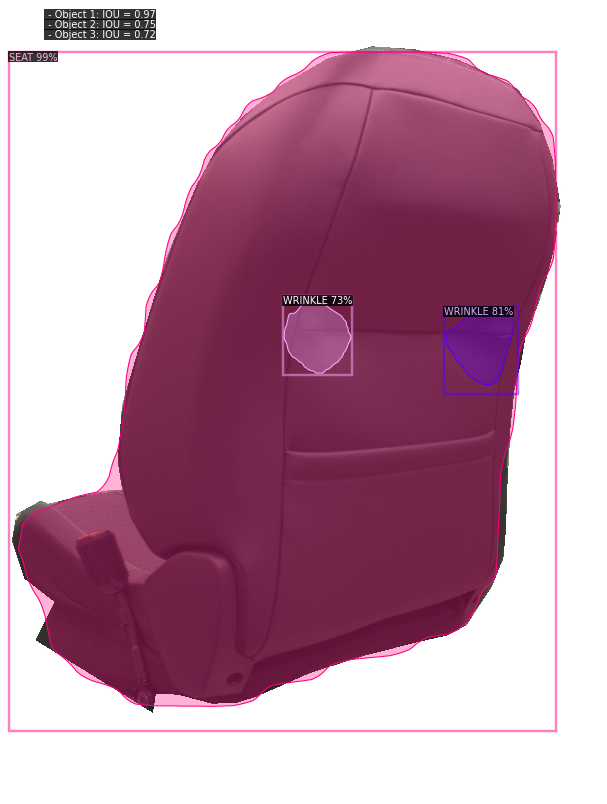

5 wrinkles to detect in this image
 - Object 1: IOU = 0.97
 - Object 2: IOU = 0.51
 - Object 3: IOU = 0.41
 - Object 4: IOU = 0.00
 - Object 5: IOU = 0.00
 - Object 6: IOU = 0.00


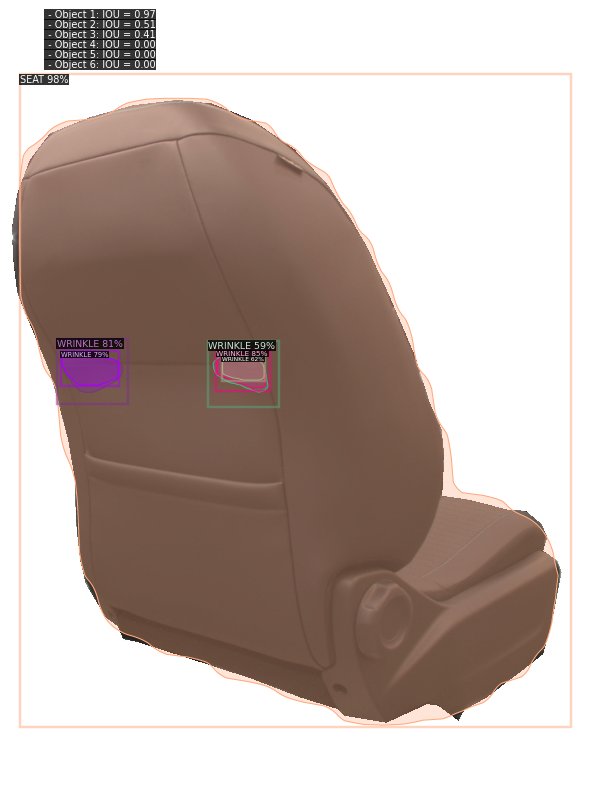

4 wrinkles to detect in this image
 - Object 1: IOU = 0.97
 - Object 2: IOU = 0.22
 - Object 3: IOU = 0.00
 - Object 4: IOU = 0.00
 - Object 5: IOU = 0.00


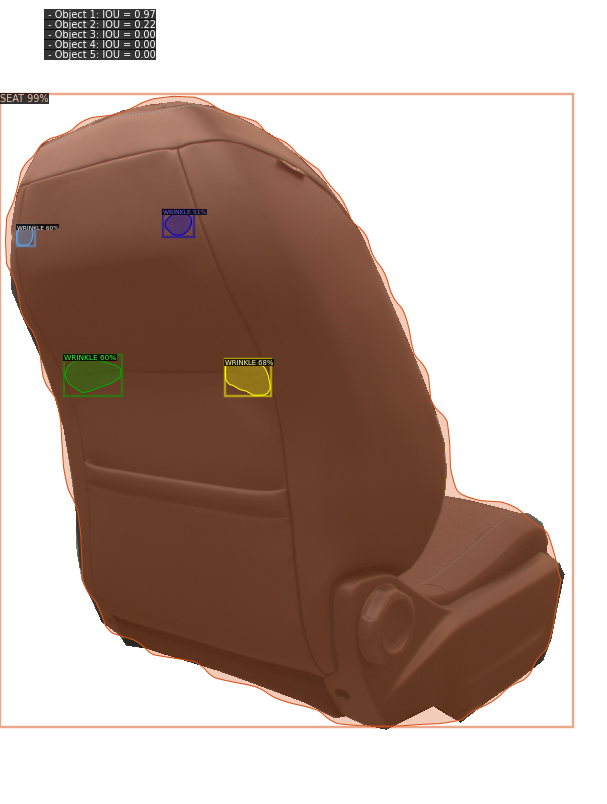

3 wrinkles to detect in this image
 - Object 1: IOU = 0.98
 - Wrinkle 2 not detected.
 - Wrinkle 3 not detected.
 - Wrinkle 4 not detected.


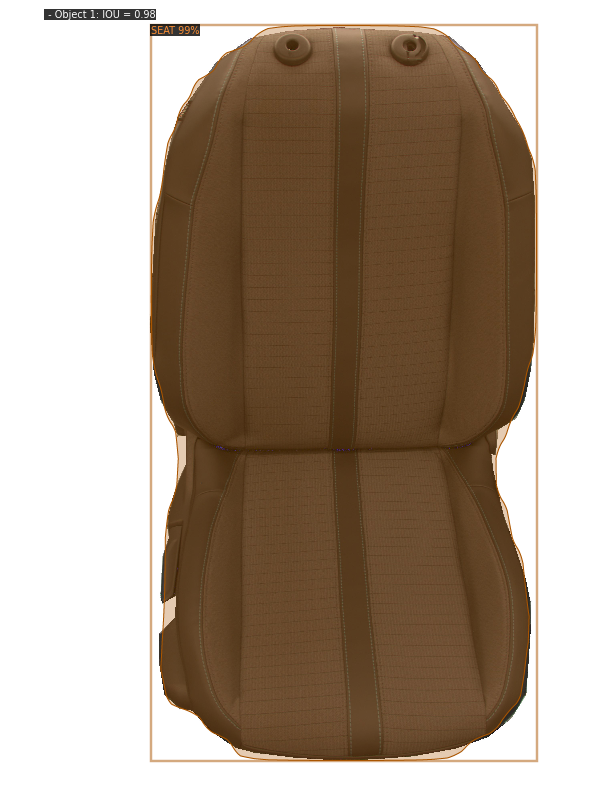

4 wrinkles to detect in this image
 - Object 1: IOU = 0.97
 - Wrinkle 2 not detected.
 - Wrinkle 3 not detected.
 - Wrinkle 4 not detected.
 - Wrinkle 5 not detected.


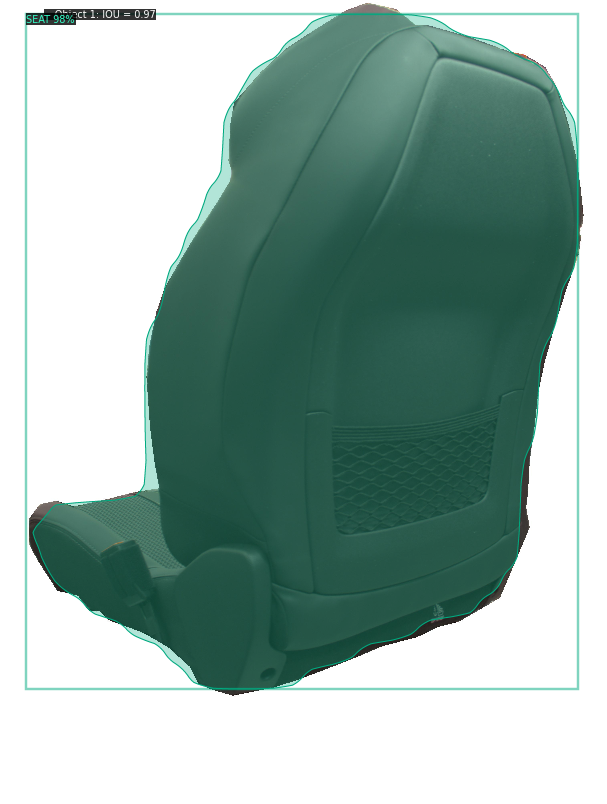

2 wrinkles to detect in this image
 - Object 1: IOU = 0.97
 - Wrinkle 2 not detected.
 - Wrinkle 3 not detected.


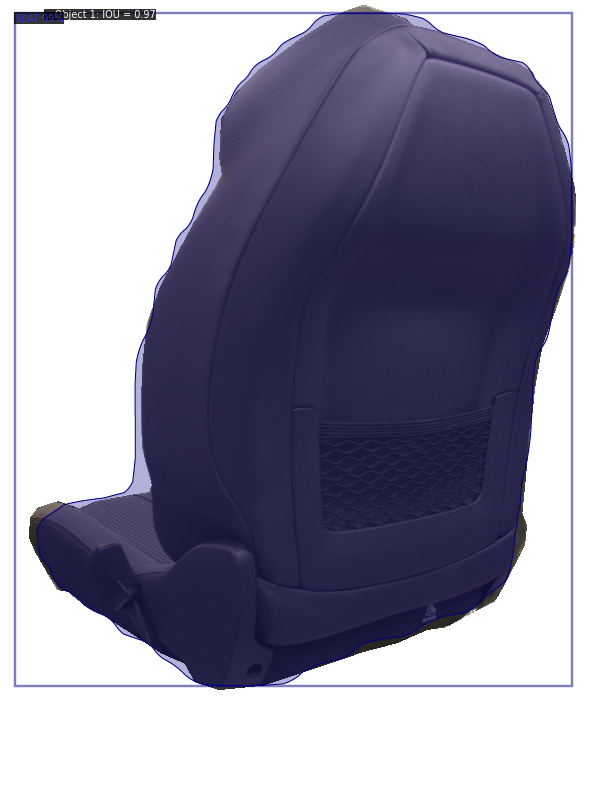

1 wrinkles to detect in this image
 - Object 1: IOU = 0.97
 - Wrinkle 2 not detected.


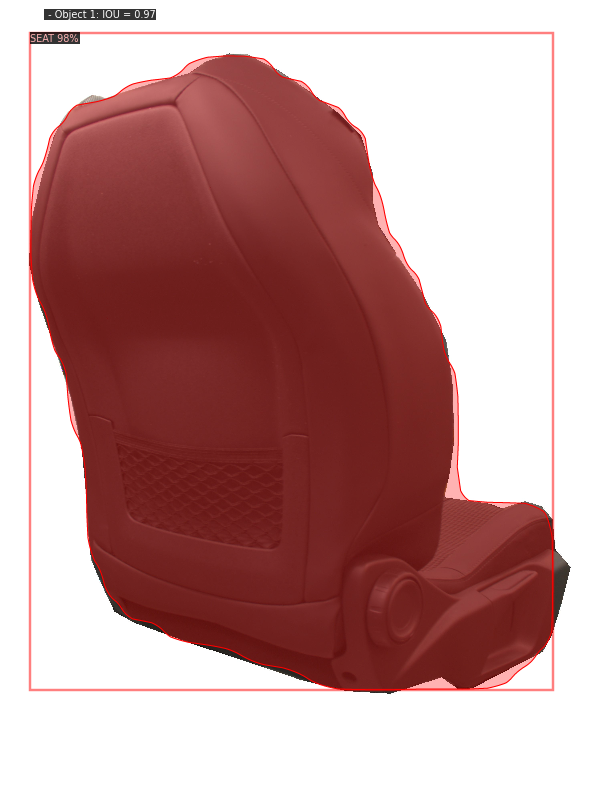

In [ ]:
# Visualize the predictions on train
visualize_predicted_images(dataset = train_dataset2, 
                           dataset_metadata = train_dataset_metadata2, 
                           predictor = my_predictor,
                           index_image=0,
                           nbr_images=1)
# test set
for i, image in enumerate(test_dataset2):
    visualize_predicted_images(dataset = test_dataset2, 
                           dataset_metadata = test_dataset_metadata2, 
                           predictor = my_predictor,
                           index_image=i)

In [ ]:
compute_iou_dataset(train_dataset2, 
                    my_predictor)


Average inference time per sample: 1.18
Average IOU: 0.26


In [ ]:
compute_iou_dataset(test_dataset2, 
                    my_predictor)


Average inference time per sample: 1.06
Average IOU: 0.27


Computing the precision and recall on the train set

In [ ]:
# inference: True positives, False positives, ...
results_train2 = compute_positives_negatives(train_dataset2, my_predictor)
results_test2 = compute_positives_negatives(test_dataset2, my_predictor)

In [ ]:
# building the confusion matrix
display(build_confusion_matrix(results_train2))
display(build_confusion_matrix(results_test2))

# precision & recall, train
print("Train set")
compute_precision_recall(results_train2)
print("\nTest set")
compute_precision_recall(results_test2)

,Predicted Positive,Predicted Negative
Actual Positive,39,40
Actual negative,38,2


,Predicted Positive,Predicted Negative
Actual Positive,9,10
Actual negative,6,0


Train set
precision: 0.506
recall: 0.494

Test set
precision: 0.600
recall: 0.474


#####**Model trained on 4 instances**:
1. Seat
2. Wrinkle_1
3. Wrinkle_2
4. Wrinkle_3


In [ ]:
# Build a predictor
output_path = "output_nobackground_differentwrinklescategories/"
yaml_path = output_path + "config.yml"
model_path = output_path + "model_final.pth"

my_predictor = inference(yaml_path, 
                         model_name=model_path, 
                         threshold=0.6)

[INFO   ] checkpoint:load:138 - Loading checkpoint from /content/drive/My Drive/ESSEC_Google_Drive/CRP_Shared/Algorithms_n_pictures/wrinkles/output_nobackground_differentwrinklescategories/model_final.pth


In [ ]:
# inference: True positives, False positives, ...
results_train2,avg_time_train = compute_positives_negatives(train_dataset2, my_predictor)
results_test2,avg_time_test = compute_positives_negatives(test_dataset2, my_predictor)

In [ ]:
# building the confusion matrix
display(build_confusion_matrix(results_train2))
display(build_confusion_matrix(results_test2))

# precision & recall, train
print("Train set")
compute_precision_recall(results_train2, avg_time_train)
print("\nTest set")
compute_precision_recall(results_test2, avg_time_test)

,Predicted Positive,Predicted Negative
Actual Positive,24,92
Actual negative,1,2


,Predicted Positive,Predicted Negative
Actual Positive,6,19
Actual negative,0,0


Train set
precision: 0.960
recall: 0.207
f1 score: 0.340
mean inference time: 0.663681834936142

Test set
precision: 1.000
recall: 0.240
f1 score: 0.387
mean inference time: 0.6190698146820068


#####**Model trained on 3 instances**:

2. Wrinkle_1
3. Wrinkle_2
4. Wrinkle_3


In [ ]:
# Build a predictor
output_path = "output_nobackground_onlywrinkles/"
yaml_path = output_path + "config.yml"
model_path = output_path + "model_final.pth"

my_predictor = inference(yaml_path, 
                         model_name=model_path, 
                         threshold=0.2)

[INFO   ] checkpoint:load:138 - Loading checkpoint from /content/drive/My Drive/ESSEC_Google_Drive/CRP_Shared/Algorithms_n_pictures/wrinkles/output_nobackground_onlywrinkles/model_final.pth


In [ ]:
# inference: True positives, False positives, ...
results_train2, avg_time_train = compute_positives_negatives(train_dataset2, my_predictor)
results_test2, avg_time_test = compute_positives_negatives(test_dataset2, my_predictor)

In [ ]:
# building the confusion matrix
display(build_confusion_matrix(results_train2))
display(build_confusion_matrix(results_test2))

# precision & recall, train
print("\nTrain set")
compute_precision_recall(results_train2, avg_time_train)
print("\nTest set")
compute_precision_recall(results_test2, avg_time_test)

,Predicted Positive,Predicted Negative
Actual Positive,32,0
Actual negative,62,1


,Predicted Positive,Predicted Negative
Actual Positive,5,6
Actual negative,7,1



Train set
precision: 0.340
recall: 1.000
f1 score: 0.508
mean inference time: 0.9934171537558237

Test set
precision: 0.417
recall: 0.455
f1 score: 0.435
mean inference time: 0.717857837677002
